In [1]:
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2024-11-26 19:59:51.382673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 19:59:52.036621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# new branch experiment
# 2

In [2]:
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)

# If you are using GPU
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [13]:
N_BLOCK = 4
LR = 0.01
OUTPUT_DIR = 1

# after the 4 divided conv1x1 108/4 = 27
IN_CHANNEL = 45

AUGMENTATION  =  30


# def random_test_choose(test_data):
#     for i in range(len(test_data)):
#         test_data[i] +=  '-' + str(random.randint(1, AUGMENTATION)) + '.'
#     return test_data



# INPUT = ['N1', 'N2']
# VALIDATION = [ 'N3']
N_SPLIT = 4

INPUT = ['N1', 'N2']
VALIDATION = [ 'N3']
ANNEALING = []

# on data aug
#TEST = ['oN4']

# on original dataset
TEST = ['oN4']

# Randomly chooses one image from the test augmented image to ensure uniqueness and integrity of the test dataset
# For example if the augmentaion scale is 10x, it means there are 10 aug images from single original image
# Since we cant include all the image to the testing because the original one image is used 10 times
# So random one image is chosen from the aug 10x imgs
#TEST = ['N4-1', 'N4-2', 'N4-3', 'N4-4', 'N4-5', 'N4-6', 'N4-7', 'N4-8', 'N4-9']
#TEST = random_test_choose(TEST)




print('Test dataset:')
print(TEST)

Test dataset:
['oN4']


In [4]:
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
# #############################
# ###bugged/ doesnt read by order
# ###Custom Function renames all files in format N1-...
# ###Only need to run it one time
# #############################

# import os
# from PIL import Image

# def rename_images(directory):
#     # Get a list of all files in the directory
#     files = os.listdir(directory)
    
#     # Filter out only the image files
#     image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
#     # Sort the image files to ensure consistent naming
#     image_files.sort()
    
#     # Initialize counter
#     counter = 1
    
#     # Iterate through the image files
#     for filename in image_files:
#         # Open the image
#         image_path = os.path.join(directory, filename)
#         with Image.open(image_path) as img:
#             # Rename the image file
#             new_filename = f"N1-{counter}" + os.path.splitext(filename)[1]
#             new_image_path = os.path.join(directory, new_filename)
            
#             # Save the image with the new name
#             img.save(new_image_path)
        
#         # Increment the counter
#         counter += 1

# # Specify the directory containing the images
# directory_path = "/home/eric/Downloads/imgNaming/processing"

# # Call the function to rename the images
# rename_images(directory_path)


In [6]:
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
date_str = '20241125-Conv1x1-' + str(OUTPUT_DIR)

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug") 

# test_data_dir = str(root_dir / "img_1006/originalTest") 
# test_labeled_dir = str(root_dir / "img_1006/testLabel") 
# test_feature_dir = str(root_dir / "img_1006/testFeature")


# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []
for raw_input_img in INPUT:
    input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
for raw_val_img in VALIDATION:
    input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
for raw_anneal in ANNEALING:
    annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
for raw_test in TEST:
    test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 




# added this part to investigate the overfitting comment out when it is done
#test_input_name = input_train
#test_input_name = input_name_val


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
print(input_train)
print(input_name_val)
print(annealing_input_name)
print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


print(len(input_train))

print(len(input_name_val))
print(len(test_input_name))
print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20241125-Conv1x1-1
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20241125-Conv1x1-1
['N1-1', 'N1-2', 'N1-3', 'N1-4', 'N1-5', 'N1-6', 'N1-7', 'N1-8', 'N1-9', 'N1-10', 'N2-1', 'N2-2', 'N2-3', 'N2-4', 'N2-5', 'N2-6', 'N2-7', 'N2-8', 'N2-9', 'N2-10']
['N3-1', 'N3-2', 'N3-3', 'N3-4', 'N3-5', 'N3-6', 'N3-7', 'N3-8', 'N3-9', 'N3-10']
[]
[]
20
10
0
0


In [7]:
# 特徴画像の特徴一覧をリストとして取得
inputfeature_list = list(map(str, InputFeature))
print(inputfeature_list)

feature_num = len(inputfeature_list)
print(feature_num)

['GRY_', 'NML1', 'NML2', 'NML3', 'TOP1', 'TOP2', 'TOP3', 'TOP4', 'SBLX', 'SBLY', 'SBLM', 'SBLD', 'SBL1', 'SBL2', 'SBL3', 'SBL4', 'LPL1', 'LPL2', 'MEA1', 'MEA2', 'GAU1', 'GAU2', 'MED1', 'MED2', 'LBP1', 'LBP2', 'LBP3', 'ETC1', 'ETC2', 'STC1', 'STC2', 'HGF_', 'NGP_', 'POS1', 'POS2', 'POS3', 'SOL_', 'EMB1', 'EMB2', 'EMB3', 'KNN1', 'KNN2', 'BLT1', 'BLT2', 'OOO_']
45


In [23]:
## 重み計算なし
def CreateWeightImage(input_number, augmentation = False):
    print("in create now")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        # commented the binary label because the project has more labels than 2 
        #_, binary_label = cv2.threshold(input_originallabel, 0, 255, cv2.THRESH_BINARY)
        
        ## This part was used for decreasing and increasing the label count when there was inconsistency with the label dataset
        
        # if len(np.unique(input_originallabel)) > 11:
        #     print("Defected image detected (more labels):" + f"{i}.png")
        #     print(np.unique(input_originallabel))
        #     for y in range(256):
        #         for x in range (256):
        #             if (input_originallabel[y][x] == 11) or (input_originallabel[y][x] == 12):
        #                 input_originallabel[y][x] = 0
        #     print(np.unique(input_originallabel))
        #     cv2.imwrite('testtttt.png', input_originallabel)
        # elif len(np.unique(input_originallabel)) < 11:
        #     print("Defected image detected (Less labels):" + f"{i}.png")
        #     defected = f"{i}_.png"
        #     print(np.unique(input_originallabel))
        #     path_to_mask = '/home/eric/Desktop/edit8label'

        #     # 25->9 32->10
        #     path_mask_abs = os.path.join(path_to_mask, defected)
        #     mask = cv2.imread(path_mask_abs, cv2.IMREAD_GRAYSCALE)
        #     for y in range(256):
        #         for x in range (256):
        #             if (input_originallabel[y][x] == 0) and (mask[y][x] == 25):
        #                 input_originallabel[y][x] = 9
        #             elif (input_originallabel[y][x] == 0) and (mask[y][x] == 32):
        #                 input_originallabel[y][x] = 10
        #     print(np.unique(input_originallabel))
        #     label_fixed_path = os.path.join(path_to_mask, f"{i}_fixed.png")
        #     cv2.imwrite(label_fixed_path, input_originallabel)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))

    for i in input_number:
        # changed this part from 100 to 256
        dataset_img = np.zeros((256, 256, feature_num), dtype=np.float32)

        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg
        # after the loop the dataset_img size will be like: (256, 256, 108) and the tensor type is np array
        
        
        
        ##this part is dividing the dataset to use multiple conv1x1 operation
        #split_dataset_img = np.array_split(dataset_img, 4, axis = 2)
        #post_conv = np.zeros((256, 256, 4), dtype=np.float32)
        #concat_list = []
        #for index, part in enumerate(split_dataset_img):
            # after this operation shape will be from (256, 256, 27) to (1, 256, 256, 27)
            #part = torch.tensor(part, dtype = torch.float32).unsqueeze(0)
            # changed the shape for the conv again now it is (1, 27, 256, 256) (batch_size, channels, height, width)
            #part = part.permute(0, 3, 1, 2)
            #fusion = nn.Conv2d(in_channels = 27, out_channels = 1, kernel_size = 1, padding = 'same')
            #output_conv = fusion(part)
            #output_conv = output_conv.squeeze(0) #.permute(1, 2, 0) # now it is (256, 256, 1)
            #output_conv = output_conv.cpu().detach().numpy()
            #post_conv[:, :, index] = output_conv[0]
            #print((output_conv).shape)
            #concat_list.append(output_conv)
            
        #concat_output = torch.cat((concat_list[0], concat_list[1], concat_list[2], concat_list[3]), dim = 2)
        ## convert the concat result tensor into numpy array and it has to be on cpu to do the operation
        #print(np.unique(output_conv.detach()))
        #concat_output = concat_output.detach()
        #concat_output = concat_output.numpy()
        
        
        #arrDataset = concat_list
        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("dataset shape ", arrDataset.shape)
    print("label shape ", np.shape(label_dataset))
    print("end create now")

    return arrDataset, label_dataset


In [10]:
# # ## Test code

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
# #Augmentation function
# # need to configure further to make it receive the new shape of the label images

# import imgaug.augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# test_data_dir = str(root_dir / "img_1006/originalTest") 
# test_labeled_dir = str(root_dir / "img_1006/testLabel") 
# test_feature_dir = str(root_dir / "img_1006/testFeature")


# ## 重み計算なし
# def ImageAug(input_number):
#     print("in aug now")
#     label_dataset = []
#     arrDataset = []
#     for i in input_number:
#         label_path = os.path.join(labeled_dir, f"{i}.png")
#         input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
#         label_dataset.append(input_originallabel)


#     print("Number of label images:", len(label_dataset))
    
#     #means x augment
#     augmentation_scale = AUGMENTATION
    
#     seq = iaa.Sequential([
#     #iaa.Fliplr(0.5),  # horizontal flip with 50% probability
#     #iaa.Flipud(0.5),  # vertical flip with 50% probability
#     iaa.Affine(
#         rotate=(-20, 20),  # rotate by -20 to +20 degrees
#         scale=(0.8, 1.2),  # scale by 80% to 120%
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}  # translate by -20% to +20%
#     ),
#     #iaa.ElasticTransformation(alpha=50, sigma=5),  # elastic deformation
#     #iaa.Multiply((0.8, 1.2)),  # change brightness
#     #iaa.LinearContrast((0.75, 1.5))  # change contrast
# ])

    
#     arr_labelDataset = []
#     for i in input_number:
#         print(i)
#         original_img_path = os.path.join(data_dir, str(i) + ".png")
#         input_original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
#         for k in range(augmentation_scale):
#             augmented = seq(image = input_original_img, segmentation_maps = SegmentationMapsOnImage(label_dataset[input_number.index(i)], shape = label_dataset[input_number.index(i)].shape))
#             arrDataset.append(np.array(augmented[0]))
#             arr_labelDataset.append(np.array(augmented[1].get_arr()))
            
#         #arrDataset = np.array(arrDataset)
#         #arr_labelDataset = np.array(arr_labelDataset)
#         for c, aug_data, aug_label in zip(range(1,augmentation_scale + 1), arrDataset, arr_labelDataset):
#             path1 = os.path.join(test_data_dir, (i + '-' + str(c)+'.png'))
#             path2 = os.path.join(test_labeled_dir, (i + '-' + str(c)+'.png'))
#             #print(path1)
#             cv2.imwrite(path1, aug_data)
#             cv2.imwrite(path2, aug_label)
        
#         arrDataset.clear()
#         arr_labelDataset.clear()
# print(file_names_with_prefix(data_dir, ''))
# ImageAug(file_names_with_prefix(data_dir, ''))


In [ ]:
from statistics import mean
# 重みを基づいて、MC画像を生成する
# function for showing MC image
# gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
def CreateWeightImageforShow(weight, input_number, index):
    sum_weight = sum(weight)  # Calculate total weight

    label_dataset = []
    input_dataset = []
    dataset_original = []

    # Read label images
    for i in input_number:
        input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
        label_dataset.append(input_originallabel)

    print('Weight image for show, label length = ', len(label_dataset))

    # Create output directory
    os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

    # Generate weighted images
    for i in input_number:
        # Create a blank image to store the weighted image, using float type for accumulation
        dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
        input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

        dataset_original.append(input_originalimg)
        for m in range(feature_num):
            input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
            # Normalize the feature image
            normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
            # Accumulate the weighted feature image
            dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

        # Normalize the accumulated image to the range 0-255
        dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
        output_img = dataset_img.astype(np.uint8)  # Convert to uint8

        input_dataset.append(output_img)
        # Write to file
        cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

    return input_dataset, label_dataset


In [ ]:
## Function to extract the weight values from the list average it and then pass the weight array to CreateWeightImageforShow
## Netron app to extract the weight tensor
## if the conv is 1x1 the tensor has 45 values
## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
def compute_mean_values(input_list):
    """
    Compute mean of 3x3 blocks in each channel of the input list.
    
    Args:
        input_list (list): A 4D list of shape (1, C, H, W).
        
    Returns:
        list: A 1D list of length C containing the mean values for each channel.
    """
    # Ensure the input is a 4D list
    if not isinstance(input_list, list) or len(input_list) != 1:
        raise ValueError("Expected input list of shape (1, C, H, W)")
    
    channels = input_list[0]  # Get the channels (C, H, W)
    
    if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
        raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
    mean_values = []
    for channel in channels:
        if not all(isinstance(row, list) for row in channel):
            raise ValueError("Each channel must contain 2D lists.")
        
        # Flatten the 2D channel to compute the mean
        flattened = [value for row in channel for value in row]
        mean_values.append(sum(flattened) / len(flattened))
    
    return mean_values


In [ ]:
## Example for creating MC image for showing

### 1X1-1029-23-n1-1
### JUST SINGLE VARIATION
weight_tensor_1x1_1029_23_n1_1 = [
    [
        [
            [
                0.048620592802762985
            ]
        ],
        [
            [
                -0.16266734898090363
            ]
        ],
        [
            [
                -0.5331748127937317
            ]
        ],
        [
            [
                0.01446301955729723
            ]
        ],
        [
            [
                0.10741645097732544
            ]
        ],
        [
            [
                -0.6900704503059387
            ]
        ],
        [
            [
                0.18237368762493134
            ]
        ],
        [
            [
                -0.23400326073169708
            ]
        ],
        [
            [
                0.42221564054489136
            ]
        ],
        [
            [
                -1.682648777961731
            ]
        ],
        [
            [
                -0.16891618072986603
            ]
        ],
        [
            [
                -0.2950967848300934
            ]
        ],
        [
            [
                -0.09502755105495453
            ]
        ],
        [
            [
                -0.5569474101066589
            ]
        ],
        [
            [
                -0.21041442453861237
            ]
        ],
        [
            [
                -0.23691624402999878
            ]
        ],
        [
            [
                -0.13884063065052032
            ]
        ],
        [
            [
                2.331940174102783
            ]
        ],
        [
            [
                1.0844106674194336
            ]
        ],
        [
            [
                2.1877870559692383
            ]
        ],
        [
            [
                0.6690412163734436
            ]
        ],
        [
            [
                1.4702367782592773
            ]
        ],
        [
            [
                0.5001341104507446
            ]
        ],
        [
            [
                0.7778019309043884
            ]
        ],
        [
            [
                0.20565907657146454
            ]
        ],
        [
            [
                0.7495082020759583
            ]
        ],
        [
            [
                0.7345373630523682
            ]
        ],
        [
            [
                0.24250063300132751
            ]
        ],
        [
            [
                -0.21307724714279175
            ]
        ],
        [
            [
                -0.45151618123054504
            ]
        ],
        [
            [
                0.040314722806215286
            ]
        ],
        [
            [
                0.30812662839889526
            ]
        ],
        [
            [
                -0.22073766589164734
            ]
        ],
        [
            [
                -0.0586552731692791
            ]
        ],
        [
            [
                -0.3032771944999695
            ]
        ],
        [
            [
                -0.5265079736709595
            ]
        ],
        [
            [
                0.09819496423006058
            ]
        ],
        [
            [
                -0.5733811855316162
            ]
        ],
        [
            [
                -1.3987427949905396
            ]
        ],
        [
            [
                -2.913318157196045
            ]
        ],
        [
            [
                -0.48010021448135376
            ]
        ],
        [
            [
                0.2108239382505417
            ]
        ],
        [
            [
                -0.4451505243778229
            ]
        ],
        [
            [
                -0.11559497565031052
            ]
        ],
        [
            [
                -0.2502543330192566
            ]
        ]
    ]
]
### 1x1, 3x3-1, 3x3-2, 5x5-1, 5x5-2 1029-36-n1-1
### Mutliple variation
#cn1
weight_tensor_1x1_1029_36_n1_1 = [
    [
        [
            [
                -1.2339791059494019
            ]
        ],
        [
            [
                -0.6323021054267883
            ]
        ],
        [
            [
                -0.7520040273666382
            ]
        ],
        [
            [
                -0.6031637787818909
            ]
        ],
        [
            [
                -1.0002880096435547
            ]
        ],
        [
            [
                -1.3431583642959595
            ]
        ],
        [
            [
                0.49285680055618286
            ]
        ],
        [
            [
                -0.7581521272659302
            ]
        ],
        [
            [
                -0.6262319087982178
            ]
        ],
        [
            [
                -1.2595927715301514
            ]
        ],
        [
            [
                -0.5647813677787781
            ]
        ],
        [
            [
                -0.41635116934776306
            ]
        ],
        [
            [
                -0.020987343043088913
            ]
        ],
        [
            [
                -1.6666197776794434
            ]
        ],
        [
            [
                -0.3615093529224396
            ]
        ],
        [
            [
                -1.276051640510559
            ]
        ],
        [
            [
                1.4189351797103882
            ]
        ],
        [
            [
                4.3346147537231445
            ]
        ],
        [
            [
                0.21334359049797058
            ]
        ],
        [
            [
                0.6982220411300659
            ]
        ],
        [
            [
                -0.14357852935791016
            ]
        ],
        [
            [
                0.024691365659236908
            ]
        ],
        [
            [
                -0.6264222264289856
            ]
        ],
        [
            [
                -0.24612516164779663
            ]
        ],
        [
            [
                0.5496180057525635
            ]
        ],
        [
            [
                0.9335170388221741
            ]
        ],
        [
            [
                0.6543871164321899
            ]
        ],
        [
            [
                -0.2968939244747162
            ]
        ],
        [
            [
                -0.25702351331710815
            ]
        ],
        [
            [
                -0.5747362375259399
            ]
        ],
        [
            [
                -0.20713959634304047
            ]
        ],
        [
            [
                -0.6044936180114746
            ]
        ],
        [
            [
                0.06788430362939835
            ]
        ],
        [
            [
                -0.11717036366462708
            ]
        ],
        [
            [
                -0.5702055096626282
            ]
        ],
        [
            [
                -0.2561193108558655
            ]
        ],
        [
            [
                -0.10170445591211319
            ]
        ],
        [
            [
                -2.0200350284576416
            ]
        ],
        [
            [
                -3.272864818572998
            ]
        ],
        [
            [
                -2.8194868564605713
            ]
        ],
        [
            [
                -0.8343505859375
            ]
        ],
        [
            [
                -0.5346056818962097
            ]
        ],
        [
            [
                -0.6521360874176025
            ]
        ],
        [
            [
                -0.374167263507843
            ]
        ],
        [
            [
                -0.32856038212776184
            ]
        ]
    ]
]
#cn2
weight_tensor_3x3_1_1029_36_n1_1 = [
    [
        [
            [
                -1.530474066734314,
                -1.6771233081817627,
                -0.8619903326034546
            ],
            [
                -1.4265605211257935,
                -1.2219780683517456,
                -0.535144567489624
            ],
            [
                -0.6436368823051453,
                -0.49976876378059387,
                -0.30685803294181824
            ]
        ],
        [
            [
                -1.0226413011550903,
                -0.822510302066803,
                0.05850622430443764
            ],
            [
                -0.7025336027145386,
                -0.43659156560897827,
                0.38603484630584717
            ],
            [
                0.2591759264469147,
                0.5617709755897522,
                0.7488081455230713
            ]
        ],
        [
            [
                -0.9138031601905823,
                -0.7948122024536133,
                -0.39947086572647095
            ],
            [
                -0.8458907604217529,
                -0.5245894193649292,
                0.08924528956413269
            ],
            [
                0.04188383370637894,
                0.15499335527420044,
                0.1826438307762146
            ]
        ],
        [
            [
                -0.7998411059379578,
                -0.7983620762825012,
                -0.3240222930908203
            ],
            [
                -0.7034404873847961,
                -0.5773715972900391,
                -0.0072261313907802105
            ],
            [
                -0.13725320994853973,
                -0.012977181002497673,
                -0.04536439850926399
            ]
        ],
        [
            [
                -0.18029724061489105,
                0.49910908937454224,
                0.815140962600708
            ],
            [
                0.3031662702560425,
                0.9217368960380554,
                1.0703445672988892
            ],
            [
                -0.4436013400554657,
                0.11309763044118881,
                0.045020755380392075
            ]
        ],
        [
            [
                -0.74969881772995,
                -0.07379722595214844,
                0.18306775391101837
            ],
            [
                0.03366607055068016,
                0.83781898021698,
                1.0045195817947388
            ],
            [
                -0.36955195665359497,
                0.5184478163719177,
                0.23326782882213593
            ]
        ],
        [
            [
                -0.13144633173942566,
                0.16150858998298645,
                0.252832293510437
            ],
            [
                -0.13816213607788086,
                0.4704318642616272,
                0.34878039360046387
            ],
            [
                -0.26693761348724365,
                0.22551371157169342,
                -0.07424211502075195
            ]
        ],
        [
            [
                -0.7202529907226562,
                0.04303884878754616,
                -0.19897015392780304
            ],
            [
                -0.5366764068603516,
                0.1969188004732132,
                0.13847783207893372
            ],
            [
                -0.4480038285255432,
                0.4617161154747009,
                0.28646862506866455
            ]
        ],
        [
            [
                -0.03014589287340641,
                1.4181952476501465,
                0.9589570760726929
            ],
            [
                -0.086050845682621,
                0.955426037311554,
                0.4025598168373108
            ],
            [
                0.06390431523323059,
                0.8387085795402527,
                -0.14713773131370544
            ]
        ],
        [
            [
                -0.8277645707130432,
                -0.7320247888565063,
                -0.4297128915786743
            ],
            [
                1.1145349740982056,
                0.9988565444946289,
                -0.44172266125679016
            ],
            [
                -0.05729737877845764,
                -0.21519999206066132,
                -1.2089422941207886
            ]
        ],
        [
            [
                0.35873061418533325,
                1.6636000871658325,
                1.5621516704559326
            ],
            [
                2.011312484741211,
                3.4271416664123535,
                2.1715497970581055
            ],
            [
                0.2247508019208908,
                1.3676265478134155,
                0.24965956807136536
            ]
        ],
        [
            [
                -0.622369647026062,
                -0.8356441259384155,
                0.060559362173080444
            ],
            [
                0.009454337880015373,
                -0.17030423879623413,
                0.2888798117637634
            ],
            [
                0.024692870676517487,
                -0.3372655510902405,
                -0.10962564498186111
            ]
        ],
        [
            [
                0.6945890784263611,
                1.193953275680542,
                1.535744071006775
            ],
            [
                -0.1051463633775711,
                0.3649017810821533,
                0.6870127320289612
            ],
            [
                -0.1591404229402542,
                0.050937458872795105,
                0.4129537045955658
            ]
        ],
        [
            [
                -0.6952106356620789,
                -0.6427516937255859,
                -0.4790618121623993
            ],
            [
                -1.0601043701171875,
                -0.8896784782409668,
                -1.0725739002227783
            ],
            [
                0.5210602879524231,
                0.5977648496627808,
                -0.49991971254348755
            ]
        ],
        [
            [
                0.7037817239761353,
                0.9409218430519104,
                1.2172961235046387
            ],
            [
                0.3540022075176239,
                0.4134519100189209,
                0.8323901891708374
            ],
            [
                -0.05920695140957832,
                0.2621106803417206,
                0.546445369720459
            ]
        ],
        [
            [
                -0.06937661021947861,
                -0.2747146487236023,
                -0.6624125242233276
            ],
            [
                -0.8107234835624695,
                -1.0369617938995361,
                -1.501963496208191
            ],
            [
                -0.20783357322216034,
                -0.3590349555015564,
                -1.1314113140106201
            ]
        ],
        [
            [
                1.988874077796936,
                2.156700611114502,
                -0.5158296227455139
            ],
            [
                1.1836724281311035,
                0.6308481097221375,
                -1.1737213134765625
            ],
            [
                0.21815688908100128,
                -0.45444461703300476,
                -0.7848373055458069
            ]
        ],
        [
            [
                5.251254558563232,
                5.130478858947754,
                0.3418044149875641
            ],
            [
                4.3343634605407715,
                2.771606922149658,
                -0.5786035060882568
            ],
            [
                1.2284586429595947,
                0.1010281890630722,
                -1.2799006700515747
            ]
        ],
        [
            [
                -0.2770380973815918,
                -0.28259211778640747,
                -0.08031351864337921
            ],
            [
                -0.25888729095458984,
                -0.2893680930137634,
                -0.026153232902288437
            ],
            [
                0.08330939710140228,
                -0.05432393401861191,
                -0.052549395710229874
            ]
        ],
        [
            [
                0.253167986869812,
                -0.04555149003863335,
                0.0026851168368011713
            ],
            [
                0.04911770671606064,
                0.11356455832719803,
                0.003676178865134716
            ],
            [
                0.13156868517398834,
                -0.14012065529823303,
                -0.1515020877122879
            ]
        ],
        [
            [
                -0.5179550051689148,
                -0.5084345936775208,
                -0.23360663652420044
            ],
            [
                -0.38293522596359253,
                -0.2976783812046051,
                -0.10341985523700714
            ],
            [
                -0.0542265921831131,
                0.035467084497213364,
                0.10315530002117157
            ]
        ],
        [
            [
                -0.25787612795829773,
                -0.2854773998260498,
                0.049469273537397385
            ],
            [
                -0.2161346673965454,
                -0.18485768139362335,
                -0.09629936516284943
            ],
            [
                0.009286767803132534,
                -0.022294307127594948,
                0.0717306137084961
            ]
        ],
        [
            [
                -0.7197384834289551,
                -0.6661694049835205,
                -0.1596246361732483
            ],
            [
                -0.6431324481964111,
                -0.6221124529838562,
                -0.00184151332359761
            ],
            [
                -0.1704903542995453,
                0.16005326807498932,
                0.09490331262350082
            ]
        ],
        [
            [
                -0.41921931505203247,
                -0.5429074764251709,
                -0.15655826032161713
            ],
            [
                -0.49500131607055664,
                -0.4686298072338104,
                -0.17474432289600372
            ],
            [
                -0.06740918755531311,
                0.09710558503866196,
                -0.0048929196782410145
            ]
        ],
        [
            [
                0.5679800510406494,
                0.4306686520576477,
                -0.19554422795772552
            ],
            [
                0.4858810305595398,
                0.04795249179005623,
                -0.6146933436393738
            ],
            [
                0.46100080013275146,
                0.11808216571807861,
                -0.2558825612068176
            ]
        ],
        [
            [
                1.0855636596679688,
                1.0835427045822144,
                0.19183671474456787
            ],
            [
                0.6261037588119507,
                -0.09971337020397186,
                -0.6415486931800842
            ],
            [
                0.9898150563240051,
                0.0999646782875061,
                0.03794555366039276
            ]
        ],
        [
            [
                0.9721496105194092,
                1.0231451988220215,
                0.3265923261642456
            ],
            [
                1.1920597553253174,
                1.198704719543457,
                0.2849370241165161
            ],
            [
                0.5190852284431458,
                0.35831528902053833,
                -0.04340706020593643
            ]
        ],
        [
            [
                -0.7368556261062622,
                -1.0984432697296143,
                -0.5795339345932007
            ],
            [
                -0.8850945234298706,
                -0.6266482472419739,
                0.005701829679310322
            ],
            [
                -0.07888568937778473,
                0.11595027148723602,
                0.33828893303871155
            ]
        ],
        [
            [
                -0.39161044359207153,
                -0.3879972994327545,
                -0.08830027282238007
            ],
            [
                -0.24516554176807404,
                -0.20340867340564728,
                0.039817485958337784
            ],
            [
                -0.02165759913623333,
                0.21646419167518616,
                0.08907293528318405
            ]
        ],
        [
            [
                -0.7219273447990417,
                -0.8596640229225159,
                -0.41423487663269043
            ],
            [
                -0.7416062355041504,
                -0.4989801347255707,
                0.05239146947860718
            ],
            [
                -0.07814644277095795,
                0.024269813671708107,
                0.29746827483177185
            ]
        ],
        [
            [
                1.105948567390442,
                1.1516954898834229,
                0.4948560297489166
            ],
            [
                0.8588804602622986,
                0.7189180254936218,
                -0.02500770054757595
            ],
            [
                -0.1737276017665863,
                -0.2748253643512726,
                -0.5755940675735474
            ]
        ],
        [
            [
                -0.9455485343933105,
                -1.4134929180145264,
                -1.0005706548690796
            ],
            [
                -0.9290593266487122,
                -1.061680555343628,
                -0.695891261100769
            ],
            [
                -0.6317973136901855,
                -0.4977881610393524,
                -0.4056662917137146
            ]
        ],
        [
            [
                0.4908067584037781,
                0.5783593058586121,
                -0.0023293583653867245
            ],
            [
                0.34753966331481934,
                0.3595527708530426,
                -0.21457286179065704
            ],
            [
                -0.15741606056690216,
                -0.29134076833724976,
                -0.40426963567733765
            ]
        ],
        [
            [
                -0.9125226140022278,
                -1.0180805921554565,
                -0.12163136899471283
            ],
            [
                -0.4479354918003082,
                -0.40414857864379883,
                0.3921678960323334
            ],
            [
                0.10026725381612778,
                0.22851347923278809,
                0.5208645462989807
            ]
        ],
        [
            [
                -0.9337403774261475,
                -1.2357004880905151,
                -0.46353691816329956
            ],
            [
                -0.9030501246452332,
                -0.7276167869567871,
                -0.1934695541858673
            ],
            [
                -0.07299597561359406,
                0.0959525778889656,
                0.12478415668010712
            ]
        ],
        [
            [
                -0.8355879187583923,
                -0.9835866093635559,
                -0.42315614223480225
            ],
            [
                -0.7176315784454346,
                -0.49347856640815735,
                0.16034480929374695
            ],
            [
                -0.2747683525085449,
                0.12356162816286087,
                0.07512029260396957
            ]
        ],
        [
            [
                -0.37675878405570984,
                -0.9298548698425293,
                -0.7643622756004333
            ],
            [
                -0.5745870471000671,
                -0.9671463370323181,
                -1.014599084854126
            ],
            [
                -1.073184847831726,
                -0.9885391592979431,
                -1.1879582405090332
            ]
        ],
        [
            [
                -1.495428204536438,
                0.06787652522325516,
                1.551397681236267
            ],
            [
                0.05969119817018509,
                1.585909366607666,
                2.725045680999756
            ],
            [
                -0.08823667466640472,
                1.1413606405258179,
                1.7120603322982788
            ]
        ],
        [
            [
                -1.777919054031372,
                -0.600269615650177,
                0.05597645416855812
            ],
            [
                -0.9107596278190613,
                -0.10723687708377838,
                0.04385574162006378
            ],
            [
                0.9711793065071106,
                1.8374125957489014,
                1.329325556755066
            ]
        ],
        [
            [
                -3.303251266479492,
                -0.8025329113006592,
                0.8004026412963867
            ],
            [
                0.6250780820846558,
                2.603372097015381,
                2.621781349182129
            ],
            [
                1.18106210231781,
                2.2162234783172607,
                1.5334560871124268
            ]
        ],
        [
            [
                -1.0664830207824707,
                -1.1443653106689453,
                -0.3645135164260864
            ],
            [
                -0.8910765647888184,
                -0.688320517539978,
                -0.0645233616232872
            ],
            [
                -0.30658507347106934,
                -0.09964465349912643,
                0.20536011457443237
            ]
        ],
        [
            [
                -1.204066276550293,
                -1.115188717842102,
                -0.5111553072929382
            ],
            [
                -1.2066150903701782,
                -0.895672619342804,
                -0.21773172914981842
            ],
            [
                -0.3439871072769165,
                -0.246653214097023,
                -0.06662189960479736
            ]
        ],
        [
            [
                -1.0488369464874268,
                -1.123544692993164,
                -0.5723265409469604
            ],
            [
                -0.9558501243591309,
                -0.7692873477935791,
                -0.1932637095451355
            ],
            [
                -0.21261416375637054,
                0.009197532199323177,
                0.21937978267669678
            ]
        ],
        [
            [
                -1.2149728536605835,
                -1.1084644794464111,
                -0.48884886503219604
            ],
            [
                -1.1715644598007202,
                -1.0800710916519165,
                -0.2567119002342224
            ],
            [
                -0.4812179207801819,
                -0.17716240882873535,
                -0.039277952164411545
            ]
        ],
        [
            [
                0.0504194051027298,
                -0.10686745494604111,
                -0.07464547455310822
            ],
            [
                0.11709411442279816,
                0.07323326915502548,
                -0.0880885198712349
            ],
            [
                0.08878365904092789,
                0.0011472422629594803,
                -0.04421848803758621
            ]
        ]
    ]
]
#cn3
weight_tensor_3x3_2_1029_36_n1_1 = [
    [
        [
            [
                -0.2101876437664032,
                -0.5047529339790344,
                0.12084823846817017
            ],
            [
                0.20694299042224884,
                0.27327588200569153,
                0.16951894760131836
            ],
            [
                0.024846792221069336,
                0.2697291672229767,
                0.13610365986824036
            ]
        ],
        [
            [
                -0.499106228351593,
                -0.8387064337730408,
                -0.5678151845932007
            ],
            [
                -0.12794142961502075,
                0.07843520492315292,
                -0.19816313683986664
            ],
            [
                -0.077767513692379,
                0.12167391926050186,
                -0.1846880465745926
            ]
        ],
        [
            [
                -0.3177783191204071,
                -0.5730440616607666,
                -0.2055501639842987
            ],
            [
                -0.06598221510648727,
                0.07700702548027039,
                -0.2094913274049759
            ],
            [
                -0.314685195684433,
                -0.05171075835824013,
                0.04617893323302269
            ]
        ],
        [
            [
                -0.20680248737335205,
                -0.5720310211181641,
                -0.034279704093933105
            ],
            [
                -0.12778429687023163,
                -0.02884678728878498,
                -0.31154918670654297
            ],
            [
                -0.17030397057533264,
                0.1554575264453888,
                0.1750110387802124
            ]
        ],
        [
            [
                0.12620645761489868,
                -0.672184944152832,
                -0.06551309674978256
            ],
            [
                -0.051199786365032196,
                -0.3375776410102844,
                0.3670078217983246
            ],
            [
                -0.3757995069026947,
                0.15127430856227875,
                0.625259518623352
            ]
        ],
        [
            [
                0.6993295550346375,
                -0.1560841202735901,
                0.5978881120681763
            ],
            [
                0.6664425730705261,
                0.6095417737960815,
                1.0365866422653198
            ],
            [
                0.6705768704414368,
                0.5194957256317139,
                1.0647751092910767
            ]
        ],
        [
            [
                -0.3430205285549164,
                -0.9297313690185547,
                -0.47151803970336914
            ],
            [
                -0.3735666275024414,
                -0.7810608148574829,
                0.10816697776317596
            ],
            [
                -0.6474761962890625,
                -0.29888105392456055,
                0.8491414785385132
            ]
        ],
        [
            [
                0.3685339391231537,
                0.21473468840122223,
                0.292662113904953
            ],
            [
                0.2779455780982971,
                0.3554166257381439,
                1.0825045108795166
            ],
            [
                0.5081647634506226,
                0.12273494899272919,
                0.9897195100784302
            ]
        ],
        [
            [
                -0.5329973697662354,
                -1.2050166130065918,
                -1.2588154077529907
            ],
            [
                -0.05721137672662735,
                -1.0695964097976685,
                -0.8896669745445251
            ],
            [
                -0.38791629672050476,
                -1.0739948749542236,
                -0.4936400055885315
            ]
        ],
        [
            [
                0.26959991455078125,
                0.6923282742500305,
                -0.15171054005622864
            ],
            [
                0.6503170728683472,
                1.3376039266586304,
                0.9910006523132324
            ],
            [
                1.1267931461334229,
                0.7628081440925598,
                1.3377364873886108
            ]
        ],
        [
            [
                -0.15263167023658752,
                -0.6667934060096741,
                -1.1088378429412842
            ],
            [
                0.509369432926178,
                -0.6192559003829956,
                -0.544900119304657
            ],
            [
                1.0619196891784668,
                -0.23895712196826935,
                0.06598387658596039
            ]
        ],
        [
            [
                1.0802689790725708,
                1.7190637588500977,
                1.3426058292388916
            ],
            [
                2.1348443031311035,
                2.7335171699523926,
                1.1310948133468628
            ],
            [
                1.861417293548584,
                1.8627671003341675,
                1.3655036687850952
            ]
        ],
        [
            [
                -1.361564040184021,
                -1.8244022130966187,
                -1.5111178159713745
            ],
            [
                -0.6239290237426758,
                -1.667370319366455,
                -1.2379260063171387
            ],
            [
                -0.9198469519615173,
                -1.2993018627166748,
                -0.8612980842590332
            ]
        ],
        [
            [
                0.7108734250068665,
                1.1679530143737793,
                0.7139098644256592
            ],
            [
                1.0974081754684448,
                1.4473901987075806,
                0.7700372934341431
            ],
            [
                1.096097469329834,
                0.28588399291038513,
                1.0118448734283447
            ]
        ],
        [
            [
                -1.1003409624099731,
                -1.816498875617981,
                -1.6505194902420044
            ],
            [
                -0.8493598699569702,
                -1.654466986656189,
                -1.4103912115097046
            ],
            [
                -0.9902585744857788,
                -1.425948143005371,
                -0.9703766107559204
            ]
        ],
        [
            [
                0.577397346496582,
                1.025193214416504,
                0.9860695004463196
            ],
            [
                0.8374137878417969,
                1.1320844888687134,
                1.1420828104019165
            ],
            [
                1.1762109994888306,
                0.8563622832298279,
                1.2675557136535645
            ]
        ],
        [
            [
                0.3880229890346527,
                -0.21074654161930084,
                -0.8612730503082275
            ],
            [
                1.2665824890136719,
                -0.7718919515609741,
                0.40947118401527405
            ],
            [
                0.890764057636261,
                0.03032243438065052,
                0.32370471954345703
            ]
        ],
        [
            [
                1.0992786884307861,
                0.48161813616752625,
                -0.3992583155632019
            ],
            [
                0.13464666903018951,
                -1.7900031805038452,
                0.33837026357650757
            ],
            [
                0.4372960925102234,
                -0.7316129803657532,
                0.11264663934707642
            ]
        ],
        [
            [
                -0.18825668096542358,
                -0.36589014530181885,
                -0.18558859825134277
            ],
            [
                -0.17219211161136627,
                -0.17230066657066345,
                -0.24895688891410828
            ],
            [
                -0.13709531724452972,
                -0.04811840504407883,
                -0.10196567326784134
            ]
        ],
        [
            [
                -0.2776859998703003,
                -0.43767377734184265,
                -0.1669798046350479
            ],
            [
                -0.3676912188529968,
                -0.2919892370700836,
                -0.2693033814430237
            ],
            [
                -0.18606096506118774,
                0.00333029730245471,
                -0.09797864407300949
            ]
        ],
        [
            [
                -0.26912954449653625,
                -0.5454427599906921,
                -0.139277383685112
            ],
            [
                -0.20801231265068054,
                -0.06033248081803322,
                -0.21170958876609802
            ],
            [
                -0.3245435059070587,
                0.08342399448156357,
                -0.12679684162139893
            ]
        ],
        [
            [
                -0.1408821940422058,
                -0.29632723331451416,
                -0.16851219534873962
            ],
            [
                -0.2420482486486435,
                -0.07064873725175858,
                -0.10824786871671677
            ],
            [
                -0.23784813284873962,
                0.024672329425811768,
                0.0945100486278534
            ]
        ],
        [
            [
                -0.22041088342666626,
                -0.6448012590408325,
                -0.1342337727546692
            ],
            [
                -0.0783320888876915,
                0.03820057585835457,
                -0.12533779442310333
            ],
            [
                -0.28373467922210693,
                0.06948481500148773,
                0.0189692210406065
            ]
        ],
        [
            [
                -0.3746541142463684,
                -0.4578709304332733,
                -0.10470283776521683
            ],
            [
                -0.18322162330150604,
                -0.12143383175134659,
                -0.26636838912963867
            ],
            [
                -0.29275938868522644,
                -0.0537421889603138,
                0.0704624280333519
            ]
        ],
        [
            [
                -0.41740158200263977,
                -0.3806077539920807,
                -0.30428966879844666
            ],
            [
                -0.44697263836860657,
                -1.139129638671875,
                -0.49162736535072327
            ],
            [
                -0.6015071272850037,
                -0.6766524910926819,
                -0.36780452728271484
            ]
        ],
        [
            [
                -0.359700083732605,
                0.009486187249422073,
                -0.05705396085977554
            ],
            [
                -0.3279534876346588,
                -0.8910983204841614,
                -0.13622307777404785
            ],
            [
                -0.7446600794792175,
                -0.34649088978767395,
                0.1035844162106514
            ]
        ],
        [
            [
                -0.3616001009941101,
                -0.08585022389888763,
                -0.1298544704914093
            ],
            [
                -0.38459184765815735,
                -1.4361186027526855,
                -0.7366841435432434
            ],
            [
                -0.09461090713739395,
                -1.0850263833999634,
                -0.8971518874168396
            ]
        ],
        [
            [
                0.021330025047063828,
                -0.2344278246164322,
                0.6733897924423218
            ],
            [
                0.1656050980091095,
                0.6764063835144043,
                0.5657141208648682
            ],
            [
                0.26517754793167114,
                0.4735383987426758,
                0.5771438479423523
            ]
        ],
        [
            [
                -0.3784654140472412,
                -0.39409610629081726,
                0.05135966092348099
            ],
            [
                -0.44986188411712646,
                -0.3569972515106201,
                -0.3682743012905121
            ],
            [
                -0.47450950741767883,
                -0.2829877436161041,
                -0.16383258998394012
            ]
        ],
        [
            [
                -0.43148142099380493,
                -0.6240154504776001,
                -0.49659523367881775
            ],
            [
                -0.02251792885363102,
                -0.017566712573170662,
                -0.1747981160879135
            ],
            [
                -0.060287658125162125,
                0.08641328662633896,
                -0.1749436855316162
            ]
        ],
        [
            [
                0.29348987340927124,
                0.6775360107421875,
                0.361976683139801
            ],
            [
                -0.010801497846841812,
                -0.12982770800590515,
                0.05769297480583191
            ],
            [
                0.10638046264648438,
                -0.09488064050674438,
                -0.12860630452632904
            ]
        ],
        [
            [
                -0.1910565048456192,
                -0.09873764961957932,
                0.9209298491477966
            ],
            [
                -0.2386046200990677,
                0.5045132040977478,
                0.74472576379776
            ],
            [
                -0.06528424471616745,
                0.5213624835014343,
                0.7253149151802063
            ]
        ],
        [
            [
                0.5188126564025879,
                0.3735431432723999,
                -0.022891918197274208
            ],
            [
                0.26614001393318176,
                -0.3514900207519531,
                0.11307363212108612
            ],
            [
                0.4829815626144409,
                0.045154690742492676,
                0.1303585320711136
            ]
        ],
        [
            [
                -0.2947569489479065,
                -0.4358474612236023,
                -0.07546451687812805
            ],
            [
                -0.1412026435136795,
                0.09261763840913773,
                -0.3663143813610077
            ],
            [
                -0.4373730719089508,
                -0.32998210191726685,
                -0.8761917352676392
            ]
        ],
        [
            [
                -0.37015268206596375,
                -0.82944256067276,
                -0.22384782135486603
            ],
            [
                -0.14256389439105988,
                0.12756980955600739,
                -0.2185617983341217
            ],
            [
                -0.3650536835193634,
                -0.07443037629127502,
                0.022138478234410286
            ]
        ],
        [
            [
                -0.6026709079742432,
                -0.7425816059112549,
                -0.2586888372898102
            ],
            [
                -0.29981669783592224,
                0.021213039755821228,
                -0.1961441934108734
            ],
            [
                -0.06330684572458267,
                0.10508072376251221,
                0.09643208235502243
            ]
        ],
        [
            [
                0.02669636905193329,
                -0.11347775906324387,
                0.47999733686447144
            ],
            [
                0.13002091646194458,
                0.15022209286689758,
                0.48945683240890503
            ],
            [
                0.3479054272174835,
                0.32498660683631897,
                0.46657657623291016
            ]
        ],
        [
            [
                -0.28574109077453613,
                -0.5022642612457275,
                -0.3582460284233093
            ],
            [
                1.1743791103363037,
                -0.09549937397241592,
                -0.8088588714599609
            ],
            [
                0.5987692475318909,
                -0.7425581812858582,
                -0.9381641149520874
            ]
        ],
        [
            [
                1.377179503440857,
                1.173900842666626,
                0.45526644587516785
            ],
            [
                1.356713056564331,
                1.808233380317688,
                1.590232491493225
            ],
            [
                0.18546324968338013,
                -0.3008946478366852,
                0.7112744450569153
            ]
        ],
        [
            [
                0.3527228832244873,
                0.13301889598369598,
                0.3402729332447052
            ],
            [
                2.065850257873535,
                1.0312401056289673,
                0.36585065722465515
            ],
            [
                0.3100891411304474,
                -0.6858291625976562,
                -0.021013282239437103
            ]
        ],
        [
            [
                -0.4339965879917145,
                -0.614194393157959,
                -0.2563331127166748
            ],
            [
                0.0433424673974514,
                0.1253303587436676,
                -0.10055825114250183
            ],
            [
                -0.10015294700860977,
                0.07469811290502548,
                0.0076498729176819324
            ]
        ],
        [
            [
                -0.4751130938529968,
                -0.6649916768074036,
                -0.12585139274597168
            ],
            [
                -0.1845252960920334,
                0.09659235924482346,
                -0.08673843741416931
            ],
            [
                -0.20792649686336517,
                0.09064612537622452,
                0.00997877586632967
            ]
        ],
        [
            [
                -0.4487493336200714,
                -0.6568391919136047,
                -0.1875254362821579
            ],
            [
                -0.047818850725889206,
                0.12697477638721466,
                -0.09935922920703888
            ],
            [
                -0.12180309742689133,
                0.01663711853325367,
                -0.013874606229364872
            ]
        ],
        [
            [
                -0.4857061207294464,
                -0.9071592688560486,
                -0.28426966071128845
            ],
            [
                -0.1835767924785614,
                -0.06735827773809433,
                -0.11710863560438156
            ],
            [
                -0.15928760170936584,
                -0.04026920720934868,
                0.00343551067635417
            ]
        ],
        [
            [
                -0.04966895654797554,
                0.11673018336296082,
                -0.10033215582370758
            ],
            [
                -0.02046378143131733,
                -0.08105802536010742,
                -0.06357716768980026
            ],
            [
                0.009034527465701103,
                0.0011474575148895383,
                -0.08881893008947372
            ]
        ]
    ]
]
#cn4
weight_tensor_5x5_1_1029_36_n1_1 = [
    [
        [
            [
                0.5917758345603943,
                0.7759135961532593,
                0.6633498668670654,
                0.40361517667770386,
                0.24470101296901703
            ],
            [
                1.1045039892196655,
                1.7795820236206055,
                1.5931645631790161,
                1.0017948150634766,
                0.33287152647972107
            ],
            [
                1.1046819686889648,
                1.8329464197158813,
                1.6197482347488403,
                1.0402182340621948,
                0.3417070508003235
            ],
            [
                0.4874836206436157,
                0.7741820812225342,
                0.6646813154220581,
                0.46689802408218384,
                0.5201983451843262
            ],
            [
                0.17829260230064392,
                0.2756533622741699,
                0.31311193108558655,
                0.35165655612945557,
                0.571965217590332
            ]
        ],
        [
            [
                0.1158081516623497,
                0.21534450352191925,
                0.07853172719478607,
                -0.2775719463825226,
                -0.5323915481567383
            ],
            [
                0.4942971169948578,
                1.3148542642593384,
                1.1286356449127197,
                0.387596070766449,
                -0.6057285666465759
            ],
            [
                0.43167802691459656,
                1.2183492183685303,
                1.0789226293563843,
                0.18424220383167267,
                -0.5504462122917175
            ],
            [
                -0.47400131821632385,
                -0.3024424910545349,
                -0.2747015357017517,
                -0.4548657238483429,
                -0.5290444493293762
            ],
            [
                -0.8780228495597839,
                -0.7869589328765869,
                -0.778083860874176,
                -0.6635684967041016,
                -0.5836482048034668
            ]
        ],
        [
            [
                0.060415077954530716,
                0.1762000173330307,
                0.07736959308385849,
                -0.12598170340061188,
                -0.30824896693229675
            ],
            [
                0.38521915674209595,
                0.9852892756462097,
                1.027204990386963,
                0.37280863523483276,
                -0.2565012574195862
            ],
            [
                0.40401843190193176,
                1.1323622465133667,
                1.0219862461090088,
                0.47389379143714905,
                -0.17600640654563904
            ],
            [
                -0.20039993524551392,
                0.036862775683403015,
                0.0640118196606636,
                -0.048733003437519073,
                0.06905556470155716
            ],
            [
                -0.5716613531112671,
                -0.39555126428604126,
                -0.3635576367378235,
                -0.26442575454711914,
                -0.0017546039307489991
            ]
        ],
        [
            [
                0.15032994747161865,
                0.2482289969921112,
                0.2233894169330597,
                0.13036613166332245,
                -0.09882078319787979
            ],
            [
                0.30376848578453064,
                1.1537926197052002,
                1.1446813344955444,
                0.502625584602356,
                -0.18081091344356537
            ],
            [
                0.3523062467575073,
                1.2416738271713257,
                1.1394519805908203,
                0.5310412049293518,
                0.042049918323755264
            ],
            [
                -0.050407323986291885,
                0.20608703792095184,
                0.1857551634311676,
                0.11612687259912491,
                0.1810978651046753
            ],
            [
                -0.4711899757385254,
                -0.24128180742263794,
                -0.15420754253864288,
                -0.14932262897491455,
                0.008658199571073055
            ]
        ],
        [
            [
                -0.8721384406089783,
                -0.38429006934165955,
                -0.35339879989624023,
                -0.5521278381347656,
                -0.29978564381599426
            ],
            [
                -0.3205614387989044,
                0.475055992603302,
                0.3171941339969635,
                -0.09167289733886719,
                0.07334475964307785
            ],
            [
                -0.2556936740875244,
                0.4954683780670166,
                0.2836350202560425,
                -0.15712924301624298,
                0.14791814982891083
            ],
            [
                -0.4292774200439453,
                0.23213312029838562,
                0.09718705713748932,
                -0.36225953698158264,
                -0.2606329321861267
            ],
            [
                1.1707375049591064,
                1.2587887048721313,
                0.24246245622634888,
                -0.7197839021682739,
                -1.3319085836410522
            ]
        ],
        [
            [
                -0.6945272088050842,
                -0.45568937063217163,
                -0.23772960901260376,
                0.10701823979616165,
                0.6854064464569092
            ],
            [
                -0.1269250363111496,
                0.8253007531166077,
                0.6216107606887817,
                0.33108285069465637,
                0.3263870179653168
            ],
            [
                -0.18814308941364288,
                0.5394662618637085,
                0.32267534732818604,
                -0.1119239404797554,
                0.18285056948661804
            ],
            [
                -0.5176292657852173,
                -0.38304489850997925,
                -0.6068260073661804,
                -0.6953670978546143,
                -0.11255431175231934
            ],
            [
                1.5798985958099365,
                1.5345866680145264,
                0.5827766060829163,
                -0.2924692630767822,
                -1.0242253541946411
            ]
        ],
        [
            [
                -0.11549483239650726,
                0.07945509999990463,
                -0.12477999925613403,
                -0.3212866187095642,
                -0.6228838562965393
            ],
            [
                0.44674229621887207,
                0.6075363159179688,
                0.04964429885149002,
                -0.19386407732963562,
                -0.22791042923927307
            ],
            [
                0.2380933165550232,
                0.6113362908363342,
                0.04638765752315521,
                -0.3918423354625702,
                -0.3235528767108917
            ],
            [
                0.007613740395754576,
                0.36844077706336975,
                0.010271423496305943,
                -0.35979703068733215,
                -0.7536553144454956
            ],
            [
                0.3247942626476288,
                0.6702722907066345,
                0.7115997672080994,
                0.3003023862838745,
                -0.34076040983200073
            ]
        ],
        [
            [
                0.08186371624469757,
                0.4934077262878418,
                0.271302193403244,
                0.0016930093988776207,
                -0.08299796283245087
            ],
            [
                0.10032129287719727,
                0.34110763669013977,
                0.04179669916629791,
                0.0033711676951497793,
                0.4009428322315216
            ],
            [
                0.36569875478744507,
                0.3902909755706787,
                -0.08323664218187332,
                -0.0742315724492073,
                0.22362367808818817
            ],
            [
                0.4904881417751312,
                0.26658543944358826,
                -0.44012874364852905,
                -0.8285883665084839,
                -0.8244768381118774
            ],
            [
                0.6935352087020874,
                0.48806828260421753,
                0.07440441846847534,
                -0.21440839767456055,
                -0.3843062222003937
            ]
        ],
        [
            [
                0.022602422162890434,
                -0.1806456446647644,
                -0.25907498598098755,
                0.11268508434295654,
                0.5065467357635498
            ],
            [
                0.7287939190864563,
                0.16347666084766388,
                -0.34427502751350403,
                -0.1777135133743286,
                0.16523659229278564
            ],
            [
                1.1268550157546997,
                0.793159008026123,
                0.06557845324277878,
                -0.1010255366563797,
                -0.15510441362857819
            ],
            [
                0.6119062304496765,
                0.6122226119041443,
                0.4006727635860443,
                0.5528149604797363,
                0.46693864464759827
            ],
            [
                0.6934973001480103,
                0.25800684094429016,
                0.12233279645442963,
                0.395243376493454,
                0.5524900555610657
            ]
        ],
        [
            [
                0.7201836705207825,
                1.9742701053619385,
                2.0615692138671875,
                1.503867506980896,
                0.8833568096160889
            ],
            [
                0.34214678406715393,
                1.382576584815979,
                2.0205514430999756,
                1.8680068254470825,
                1.526654839515686
            ],
            [
                -0.3661162257194519,
                -0.7679178714752197,
                -0.3999105393886566,
                0.6205304861068726,
                1.9234936237335205
            ],
            [
                0.046832580119371414,
                -0.5321187376976013,
                -0.6485140919685364,
                0.032406874001026154,
                1.1207278966903687
            ],
            [
                -0.16796688735485077,
                -0.23592346906661987,
                -0.2641650438308716,
                -0.26456159353256226,
                -0.2458096444606781
            ]
        ],
        [
            [
                0.8602230548858643,
                1.5776209831237793,
                1.1583596467971802,
                0.856214165687561,
                0.549021303653717
            ],
            [
                1.0074692964553833,
                1.0872013568878174,
                0.6200098395347595,
                0.6482793092727661,
                0.8616126179695129
            ],
            [
                0.8894470930099487,
                -0.37205740809440613,
                -1.1927337646484375,
                -0.724852442741394,
                0.6467681527137756
            ],
            [
                1.4972976446151733,
                0.5268767476081848,
                -0.4250708818435669,
                -0.2239421010017395,
                0.7789417505264282
            ],
            [
                1.1630487442016602,
                1.0697743892669678,
                0.845589280128479,
                0.7094410061836243,
                0.517941951751709
            ]
        ],
        [
            [
                -1.6508971452713013,
                -1.0431931018829346,
                -0.4382750689983368,
                -0.6100504398345947,
                -0.90971440076828
            ],
            [
                -0.6549960970878601,
                -0.192494735121727,
                -0.13081347942352295,
                -0.5071864724159241,
                -0.9447193741798401
            ],
            [
                -0.7861413955688477,
                -0.7356007695198059,
                -0.7755562663078308,
                -0.6641557812690735,
                0.09864888340234756
            ],
            [
                -1.2114291191101074,
                -1.067043423652649,
                -0.6907533407211304,
                -0.21837276220321655,
                0.5367453098297119
            ],
            [
                -1.5525214672088623,
                -0.9760769009590149,
                -0.04494928941130638,
                0.13268697261810303,
                0.12183048576116562
            ]
        ],
        [
            [
                0.4206836223602295,
                -0.4254862368106842,
                -0.7442447543144226,
                -0.43585434556007385,
                -0.29329296946525574
            ],
            [
                1.2416749000549316,
                0.22885839641094208,
                -0.2986662983894348,
                -0.4363304674625397,
                -0.3905490040779114
            ],
            [
                1.839713215827942,
                1.1501411199569702,
                0.6785497665405273,
                0.09194239228963852,
                -0.41600361466407776
            ],
            [
                1.346191167831421,
                1.059528112411499,
                0.8622688055038452,
                0.5155429840087891,
                0.10014545172452927
            ],
            [
                0.9227443933486938,
                0.5292174220085144,
                0.28444018959999084,
                0.44236284494400024,
                0.41916781663894653
            ]
        ],
        [
            [
                0.4658812880516052,
                0.8549314141273499,
                0.863177478313446,
                0.7236819863319397,
                0.5661482810974121
            ],
            [
                -0.05327266827225685,
                0.21873553097248077,
                0.40947166085243225,
                0.4895339608192444,
                0.5419774651527405
            ],
            [
                0.5198606252670288,
                0.685275137424469,
                0.7024667263031006,
                0.8054167032241821,
                0.8621476292610168
            ],
            [
                -0.32625529170036316,
                -0.742891788482666,
                -0.8304277658462524,
                -0.11921671032905579,
                0.8449581861495972
            ],
            [
                -0.35788393020629883,
                -0.8003108501434326,
                -0.9238467216491699,
                -0.31146204471588135,
                0.349325954914093
            ]
        ],
        [
            [
                0.3897183835506439,
                -0.38073843717575073,
                -0.7074125409126282,
                -0.725123405456543,
                -0.6348734498023987
            ],
            [
                0.9363428354263306,
                0.09510236978530884,
                -0.1709510236978531,
                -0.25734081864356995,
                -0.4431101083755493
            ],
            [
                1.3092472553253174,
                0.6299477219581604,
                0.35994449257850647,
                0.0759420171380043,
                -0.24798032641410828
            ],
            [
                1.2359739542007446,
                0.9058071970939636,
                0.689345121383667,
                0.4813210666179657,
                0.15722645819187164
            ],
            [
                1.4127707481384277,
                0.921887993812561,
                0.4052657186985016,
                0.18891744315624237,
                0.0671687200665474
            ]
        ],
        [
            [
                -0.1811491996049881,
                0.15843574702739716,
                0.3103863000869751,
                0.45948484539985657,
                0.6357889771461487
            ],
            [
                -0.48790955543518066,
                -0.20737648010253906,
                -0.11989305168390274,
                0.22021356225013733,
                0.48444727063179016
            ],
            [
                0.3452417254447937,
                0.40907981991767883,
                0.39835217595100403,
                0.558754026889801,
                0.7295740842819214
            ],
            [
                0.07105688005685806,
                -0.3055444061756134,
                -0.31106528639793396,
                0.04508687183260918,
                0.7222288250923157
            ],
            [
                -0.032346855849027634,
                -0.3642876446247101,
                -0.34220486879348755,
                -0.14711108803749084,
                0.24277308583259583
            ]
        ],
        [
            [
                -0.3356251120567322,
                0.5646682381629944,
                0.7933211922645569,
                1.257285714149475,
                0.9973092079162598
            ],
            [
                1.3085496425628662,
                -0.027182726189494133,
                -0.2575701177120209,
                1.4892421960830688,
                2.844024419784546
            ],
            [
                0.9410516023635864,
                -0.41772499680519104,
                -0.5409399271011353,
                1.1699186563491821,
                1.9757813215255737
            ],
            [
                0.737831175327301,
                1.7219829559326172,
                1.7494125366210938,
                0.9464563131332397,
                -0.6661105751991272
            ],
            [
                -1.3233333826065063,
                -0.9137702584266663,
                -0.4834846258163452,
                -0.377957820892334,
                -1.170425295829773
            ]
        ],
        [
            [
                -0.39313188195228577,
                0.10256803035736084,
                0.1770496815443039,
                0.9460238218307495,
                1.0648202896118164
            ],
            [
                -0.720664381980896,
                -2.3023362159729004,
                -2.5624189376831055,
                0.2051527202129364,
                2.60526704788208
            ],
            [
                -1.2367804050445557,
                -3.037165880203247,
                -2.823720932006836,
                -0.210847407579422,
                1.5497077703475952
            ],
            [
                0.6405010223388672,
                1.2146587371826172,
                1.260146141052246,
                0.9944579005241394,
                -0.4713019132614136
            ],
            [
                -0.06688614934682846,
                0.454367071390152,
                0.5011420845985413,
                -0.014314556494355202,
                -1.1440105438232422
            ]
        ],
        [
            [
                0.17764192819595337,
                0.3359419107437134,
                0.2811047434806824,
                0.10721415281295776,
                -0.13225476443767548
            ],
            [
                0.13606001436710358,
                0.6171552538871765,
                0.5952663421630859,
                0.18311700224876404,
                -0.14806030690670013
            ],
            [
                0.07920026034116745,
                0.582838773727417,
                0.5573250651359558,
                0.17393481731414795,
                -0.12716682255268097
            ],
            [
                -0.08309949934482574,
                0.28797534108161926,
                0.20313553512096405,
                0.10610780119895935,
                0.054313648492097855
            ],
            [
                -0.57691890001297,
                -0.3939898908138275,
                -0.2983768582344055,
                -0.27641230821609497,
                -0.17801706492900848
            ]
        ],
        [
            [
                0.06981920450925827,
                0.18699853122234344,
                0.23851709067821503,
                0.1578758805990219,
                -0.14196926355361938
            ],
            [
                -0.03783854469656944,
                0.22866183519363403,
                0.11093905568122864,
                0.1213940903544426,
                -0.12368163466453552
            ],
            [
                -0.19733119010925293,
                0.1918146014213562,
                0.22751674056053162,
                0.0362100712954998,
                -0.0625249519944191
            ],
            [
                -0.17015495896339417,
                0.16828292608261108,
                0.17338229715824127,
                0.2494198977947235,
                0.01317229587584734
            ],
            [
                -0.4566766023635864,
                -0.18617521226406097,
                -0.12419934570789337,
                -0.1268584430217743,
                -0.18013963103294373
            ]
        ],
        [
            [
                0.08301850408315659,
                0.33357375860214233,
                0.22022689878940582,
                0.09136846661567688,
                -0.15370482206344604
            ],
            [
                0.21668867766857147,
                0.7851912379264832,
                0.7453020215034485,
                0.328332781791687,
                -0.21774087846279144
            ],
            [
                0.11065923422574997,
                0.6893627047538757,
                0.7502142786979675,
                0.3309404253959656,
                -0.12320704758167267
            ],
            [
                -0.06959418207406998,
                0.1936110556125641,
                0.17498883605003357,
                0.1352984607219696,
                0.029857218265533447
            ],
            [
                -0.5735039114952087,
                -0.3405883312225342,
                -0.3398568034172058,
                -0.25304552912712097,
                -0.06945629417896271
            ]
        ],
        [
            [
                0.040591657161712646,
                0.2609267830848694,
                0.3050239086151123,
                0.11949589848518372,
                -0.20655009150505066
            ],
            [
                0.12151332199573517,
                0.3886139988899231,
                0.3961934745311737,
                0.09893768280744553,
                -0.1905643194913864
            ],
            [
                -0.0593496710062027,
                0.4440290331840515,
                0.43444281816482544,
                0.22409018874168396,
                -0.17997857928276062
            ],
            [
                -0.2448776811361313,
                0.20945033431053162,
                0.22785584628582,
                0.15480370819568634,
                0.0647766962647438
            ],
            [
                -0.5193992853164673,
                -0.3143548369407654,
                -0.2617773413658142,
                -0.2713790833950043,
                -0.2320568710565567
            ]
        ],
        [
            [
                -0.030790595337748528,
                0.17791007459163666,
                0.12951813638210297,
                -0.06200193986296654,
                -0.3143438994884491
            ],
            [
                0.2061736136674881,
                0.9194480180740356,
                0.8374773859977722,
                0.29451504349708557,
                -0.2533913254737854
            ],
            [
                0.28377023339271545,
                1.0675991773605347,
                0.9529463648796082,
                0.3715042471885681,
                -0.1605798751115799
            ],
            [
                -0.23810826241970062,
                0.12327498197555542,
                0.18724843859672546,
                0.06754900515079498,
                0.12238692492246628
            ],
            [
                -0.6338501572608948,
                -0.3322051763534546,
                -0.3022273778915405,
                -0.14720170199871063,
                -0.09669660776853561
            ]
        ],
        [
            [
                0.002705104649066925,
                0.2730924189090729,
                0.14850682020187378,
                0.022853270173072815,
                -0.3602519929409027
            ],
            [
                0.11072634905576706,
                0.6262199282646179,
                0.5762306451797485,
                0.2671821415424347,
                -0.27685099840164185
            ],
            [
                0.13907448947429657,
                0.7961697578430176,
                0.8041945099830627,
                0.30858296155929565,
                -0.044156115502119064
            ],
            [
                -0.18902425467967987,
                0.2692444622516632,
                0.19133730232715607,
                0.12707389891147614,
                -0.004163860343396664
            ],
            [
                -0.548709511756897,
                -0.37843772768974304,
                -0.22634345293045044,
                -0.1671513468027115,
                -0.1355494111776352
            ]
        ],
        [
            [
                0.23325881361961365,
                0.48247912526130676,
                0.5463142991065979,
                0.44132304191589355,
                -0.09284757077693939
            ],
            [
                0.5316913723945618,
                0.28529831767082214,
                0.16701923310756683,
                0.4373159408569336,
                0.3969370126724243
            ],
            [
                0.12881174683570862,
                0.08849222213029861,
                0.24514375627040863,
                0.5469391345977783,
                0.34865602850914
            ],
            [
                0.2908725440502167,
                0.5356733798980713,
                0.6976057887077332,
                0.4270128309726715,
                -0.29462912678718567
            ],
            [
                0.007303101010620594,
                0.29154258966445923,
                0.1773982048034668,
                -0.03635811433196068,
                0.007753939833492041
            ]
        ],
        [
            [
                -0.24620407819747925,
                0.3933700621128082,
                0.7842179536819458,
                0.6990868449211121,
                -0.05085672438144684
            ],
            [
                0.27696651220321655,
                0.03190504387021065,
                -0.11317341774702072,
                0.046442579478025436,
                0.07987278699874878
            ],
            [
                -0.016537191346287727,
                0.050274044275283813,
                0.26438218355178833,
                0.4659719169139862,
                0.05762333422899246
            ],
            [
                0.2526462972164154,
                0.7854140996932983,
                0.8238452672958374,
                0.390394926071167,
                -0.5355395674705505
            ],
            [
                -0.294848769903183,
                -0.2573196589946747,
                -0.394732803106308,
                -0.37571242451667786,
                0.09387760609388351
            ]
        ],
        [
            [
                -0.3500092029571533,
                -0.02975827269256115,
                0.2520546019077301,
                0.16662639379501343,
                -0.2721683979034424
            ],
            [
                -0.19279462099075317,
                -0.24240560829639435,
                -0.10885421931743622,
                0.11922983080148697,
                0.19131535291671753
            ],
            [
                -0.16005022823810577,
                -0.5878947973251343,
                -0.7146655917167664,
                -0.4025256931781769,
                0.008111216127872467
            ],
            [
                0.07620495557785034,
                0.3507486879825592,
                0.38868436217308044,
                0.21616677939891815,
                -0.30121421813964844
            ],
            [
                0.14857082068920135,
                0.766622006893158,
                1.0552853345870972,
                0.7953652739524841,
                0.08186740428209305
            ]
        ],
        [
            [
                -0.7386455535888672,
                -0.4603317975997925,
                -0.594118595123291,
                -0.8734692931175232,
                -1.1035703420639038
            ],
            [
                -0.3661314845085144,
                0.42565175890922546,
                0.39908987283706665,
                -0.5002111792564392,
                -1.4443236589431763
            ],
            [
                -0.5255719423294067,
                0.3994710445404053,
                0.19023644924163818,
                -0.6358333230018616,
                -1.5470831394195557
            ],
            [
                -1.088446855545044,
                -0.8748226761817932,
                -1.0145363807678223,
                -1.317643642425537,
                -1.5876973867416382
            ],
            [
                -1.4536826610565186,
                -1.38155198097229,
                -1.6563212871551514,
                -1.5904239416122437,
                -1.55363929271698
            ]
        ],
        [
            [
                0.12917429208755493,
                0.19433754682540894,
                0.19495247304439545,
                0.19995054602622986,
                0.10045955330133438
            ],
            [
                0.2955339848995209,
                0.7534978985786438,
                0.6748557686805725,
                0.4820772707462311,
                0.15305954217910767
            ],
            [
                0.4830479919910431,
                0.8707234263420105,
                0.8912374973297119,
                0.6703752875328064,
                0.41402456164360046
            ],
            [
                0.2818300127983093,
                0.47946950793266296,
                0.5571016073226929,
                0.5670326948165894,
                0.7671869397163391
            ],
            [
                0.045472946017980576,
                0.3481485843658447,
                0.43908214569091797,
                0.49295270442962646,
                0.7540217638015747
            ]
        ],
        [
            [
                0.15154701471328735,
                0.5889304876327515,
                0.5814750790596008,
                0.2764393091201782,
                -0.04388974606990814
            ],
            [
                0.6886104941368103,
                1.3443862199783325,
                1.375622034072876,
                0.6189591884613037,
                -0.08760074526071548
            ],
            [
                0.46692195534706116,
                1.0504629611968994,
                0.9650806784629822,
                0.23638024926185608,
                -0.3788227438926697
            ],
            [
                -0.5280950665473938,
                -0.2589721083641052,
                -0.3243270516395569,
                -0.4432002007961273,
                -0.7704470753669739
            ],
            [
                -0.8049659132957458,
                -0.8410757184028625,
                -0.8286128044128418,
                -0.8468789458274841,
                -0.8621377944946289
            ]
        ],
        [
            [
                -0.056551963090896606,
                -0.37489548325538635,
                -0.3310781419277191,
                0.0038002554792910814,
                0.4111477732658386
            ],
            [
                -0.6226459741592407,
                -1.314456582069397,
                -1.2415549755096436,
                -0.4021560251712799,
                0.4579779803752899
            ],
            [
                -0.2700643539428711,
                -0.7492929100990295,
                -0.6579148173332214,
                -0.017881782725453377,
                0.7950633764266968
            ],
            [
                0.6220977306365967,
                0.5491485595703125,
                0.6419872045516968,
                0.888501763343811,
                1.0549503564834595
            ],
            [
                0.8683240413665771,
                0.9234111905097961,
                1.0000368356704712,
                0.9969467520713806,
                1.136812448501587
            ]
        ],
        [
            [
                0.634261965751648,
                1.0211293697357178,
                1.2018553018569946,
                0.835063636302948,
                0.5100634694099426
            ],
            [
                0.9583927392959595,
                1.5894888639450073,
                1.626315712928772,
                0.8179321885108948,
                0.04208473861217499
            ],
            [
                0.838005542755127,
                1.385074257850647,
                1.2361431121826172,
                0.48960447311401367,
                -0.1862020492553711
            ],
            [
                0.48997899889945984,
                0.532439649105072,
                0.42277052998542786,
                0.02218000218272209,
                -0.2703879773616791
            ],
            [
                0.20830973982810974,
                0.20087939500808716,
                -0.1674414426088333,
                -0.4059534966945648,
                -0.43384596705436707
            ]
        ],
        [
            [
                0.14463837444782257,
                0.2826870381832123,
                0.4859692454338074,
                0.6693779826164246,
                0.8263519406318665
            ],
            [
                -0.16339674592018127,
                -0.6761521697044373,
                -0.5144345164299011,
                0.0394676998257637,
                0.6604802012443542
            ],
            [
                -0.18927893042564392,
                -0.6202464699745178,
                -0.489583820104599,
                0.03071882389485836,
                0.6210110783576965
            ],
            [
                0.36295121908187866,
                0.3364141881465912,
                0.4114437997341156,
                0.4821345806121826,
                0.5898239612579346
            ],
            [
                0.3745045065879822,
                0.32243508100509644,
                0.4578656256198883,
                0.4390532076358795,
                0.30396077036857605
            ]
        ],
        [
            [
                0.1772255152463913,
                0.3804987072944641,
                0.20862016081809998,
                -0.03295711427927017,
                -0.32868891954421997
            ],
            [
                0.27122828364372253,
                1.0645517110824585,
                1.0168999433517456,
                0.35681775212287903,
                -0.4192609488964081
            ],
            [
                -0.11023537069559097,
                0.7878332138061523,
                0.7672415375709534,
                0.0712767243385315,
                -0.4805324673652649
            ],
            [
                -0.5707201361656189,
                -0.15228453278541565,
                -0.15997862815856934,
                -0.3234413266181946,
                -0.3705575466156006
            ],
            [
                -0.60770583152771,
                -0.37013790011405945,
                -0.3486829698085785,
                -0.24026644229888916,
                -0.18361403048038483
            ]
        ],
        [
            [
                0.2609538435935974,
                0.44675010442733765,
                0.4808134436607361,
                0.39863184094429016,
                0.09795186668634415
            ],
            [
                0.4525032341480255,
                1.2016146183013916,
                1.394208312034607,
                0.6992467641830444,
                -0.00408845255151391
            ],
            [
                0.37615394592285156,
                1.119931697845459,
                1.1124470233917236,
                0.6408483386039734,
                0.035162851214408875
            ],
            [
                -0.12270770967006683,
                0.1272726058959961,
                0.19384528696537018,
                0.08078204095363617,
                0.14981527626514435
            ],
            [
                -0.33441397547721863,
                -0.2530401051044464,
                -0.25883185863494873,
                -0.35839468240737915,
                -0.2380908578634262
            ]
        ],
        [
            [
                0.11693572998046875,
                0.38308975100517273,
                0.34887635707855225,
                0.1879798322916031,
                0.013866373337805271
            ],
            [
                0.5933656692504883,
                1.3679598569869995,
                1.374388337135315,
                0.6970495581626892,
                0.038205597549676895
            ],
            [
                0.6176865100860596,
                1.3117728233337402,
                1.1600968837738037,
                0.5291932821273804,
                -0.03781987726688385
            ],
            [
                0.1043066456913948,
                0.2866966724395752,
                0.2664016783237457,
                0.24384979903697968,
                0.25544580817222595
            ],
            [
                -0.3431985378265381,
                -0.038906555622816086,
                -0.011525491252541542,
                0.06285825371742249,
                0.13865375518798828
            ]
        ],
        [
            [
                0.09208139777183533,
                0.5173308849334717,
                0.6638443470001221,
                0.5164546966552734,
                0.1518062949180603
            ],
            [
                0.6943270564079285,
                1.1397658586502075,
                0.9417056441307068,
                0.5847949981689453,
                0.1948477178812027
            ],
            [
                0.5946874618530273,
                0.6712698936462402,
                0.7252604961395264,
                0.587800145149231,
                0.3420139253139496
            ],
            [
                0.2757835388183594,
                0.4795048236846924,
                0.3854540288448334,
                0.49341946840286255,
                0.27962303161621094
            ],
            [
                -0.03730035945773125,
                -0.11685644835233688,
                -0.1995183378458023,
                -0.231806218624115,
                -0.22863689064979553
            ]
        ],
        [
            [
                2.832526206970215,
                1.8458471298217773,
                0.5459241271018982,
                -0.5589001774787903,
                -1.1303154230117798
            ],
            [
                3.617994785308838,
                2.473155975341797,
                0.6551885604858398,
                -0.7317020893096924,
                -1.2546334266662598
            ],
            [
                1.2462221384048462,
                0.08792697638273239,
                -1.1070530414581299,
                -1.8693726062774658,
                -1.8307304382324219
            ],
            [
                0.3378757834434509,
                -0.38716575503349304,
                -1.0776923894882202,
                -1.3620134592056274,
                -1.1910258531570435
            ],
            [
                0.8019360303878784,
                0.5085671544075012,
                0.11869080364704132,
                -0.13867305219173431,
                -0.2951337397098541
            ]
        ],
        [
            [
                2.285780191421509,
                3.4199745655059814,
                2.8320791721343994,
                1.9194093942642212,
                1.4142391681671143
            ],
            [
                0.702529788017273,
                1.4768201112747192,
                1.1979552507400513,
                0.8668068647384644,
                1.0419598817825317
            ],
            [
                0.08718109130859375,
                0.4868260622024536,
                0.21769656240940094,
                0.12892092764377594,
                0.485456258058548
            ],
            [
                -0.9119054079055786,
                -1.4686249494552612,
                -1.8853198289871216,
                -1.6070282459259033,
                -0.6842339038848877
            ],
            [
                -1.0155259370803833,
                -1.822827696800232,
                -2.4189138412475586,
                -2.3076844215393066,
                -1.6210685968399048
            ]
        ],
        [
            [
                3.7448222637176514,
                4.409781455993652,
                3.0135536193847656,
                1.3420772552490234,
                0.4926777780056
            ],
            [
                3.888321876525879,
                4.113893032073975,
                2.444056272506714,
                0.720792829990387,
                0.11367464810609818
            ],
            [
                0.11916261166334152,
                -0.7218382954597473,
                -1.7342480421066284,
                -1.8502249717712402,
                -0.9131169319152832
            ],
            [
                -1.0938868522644043,
                -1.865311861038208,
                -2.3804585933685303,
                -1.9106584787368774,
                -0.6840957403182983
            ],
            [
                0.03132854402065277,
                -0.2325250804424286,
                -0.5566985011100769,
                -0.44028031826019287,
                -0.3954392075538635
            ]
        ],
        [
            [
                0.17355678975582123,
                0.3691652715206146,
                0.4597315490245819,
                0.24378429353237152,
                0.03441888466477394
            ],
            [
                0.37195470929145813,
                1.1212366819381714,
                1.1749916076660156,
                0.5764731764793396,
                -0.1804770529270172
            ],
            [
                0.3034372627735138,
                1.1769458055496216,
                1.269781231880188,
                0.6032124757766724,
                -0.0399058498442173
            ],
            [
                -0.29646292328834534,
                0.14363889396190643,
                0.17859134078025818,
                0.07167815417051315,
                0.08138330280780792
            ],
            [
                -0.5256922841072083,
                -0.29087191820144653,
                -0.14208649098873138,
                -0.10962246358394623,
                0.1890019178390503
            ]
        ],
        [
            [
                0.0646563395857811,
                0.28639209270477295,
                0.3408071994781494,
                0.19667549431324005,
                -0.028312144801020622
            ],
            [
                0.4906112849712372,
                1.4233384132385254,
                1.4331324100494385,
                0.7653583288192749,
                0.01259151566773653
            ],
            [
                0.5968948602676392,
                1.5004724264144897,
                1.4415212869644165,
                0.8287730813026428,
                0.2282170206308365
            ],
            [
                -0.06094781309366226,
                0.3595283031463623,
                0.3994508683681488,
                0.2717183530330658,
                0.3243110477924347
            ],
            [
                -0.3578152656555176,
                -0.00012221632641740143,
                0.03417526185512543,
                0.064755879342556,
                0.26406577229499817
            ]
        ],
        [
            [
                0.10087347030639648,
                0.41437315940856934,
                0.3641204535961151,
                0.2542209029197693,
                0.13125932216644287
            ],
            [
                0.46739837527275085,
                1.1133297681808472,
                1.2085071802139282,
                0.6395747065544128,
                -0.1422218680381775
            ],
            [
                0.387254536151886,
                1.3245248794555664,
                1.241894245147705,
                0.6867668628692627,
                0.10616356879472733
            ],
            [
                -0.2579864263534546,
                0.15172357857227325,
                0.21188659965991974,
                0.03977097198367119,
                0.1622062623500824
            ],
            [
                -0.4853610694408417,
                -0.19110877811908722,
                -0.1956993043422699,
                -0.021668480709195137,
                0.0870407447218895
            ]
        ],
        [
            [
                0.0324532575905323,
                0.33808109164237976,
                0.35987451672554016,
                0.08852191269397736,
                -0.11208543926477432
            ],
            [
                0.5300487875938416,
                1.4429516792297363,
                1.456619381904602,
                0.7450541853904724,
                0.10425092279911041
            ],
            [
                0.6591262221336365,
                1.6143866777420044,
                1.63541579246521,
                0.9033617377281189,
                0.26741766929626465
            ],
            [
                0.042052559554576874,
                0.29331544041633606,
                0.3321380019187927,
                0.23959830403327942,
                0.3143129348754883
            ],
            [
                -0.30914023518562317,
                -0.03315054625272751,
                0.13531138002872467,
                0.06757373362779617,
                0.2891596853733063
            ]
        ],
        [
            [
                -0.014986667782068253,
                -0.0023221676237881184,
                0.04506879672408104,
                -0.010595477186143398,
                0.016790155321359634
            ],
            [
                0.018902549520134926,
                0.027165396139025688,
                -0.0022671110928058624,
                0.04102012515068054,
                0.029597394168376923
            ],
            [
                0.059812095016241074,
                -0.0514831505715847,
                0.0197967067360878,
                -0.043070100247859955,
                0.05655580013990402
            ],
            [
                0.015110609121620655,
                0.0029190934728831053,
                0.05465828254818916,
                0.05905938521027565,
                -0.0117014916613698
            ],
            [
                -0.022601356729865074,
                0.00893819984048605,
                0.04623069614171982,
                0.03439392149448395,
                -0.034771181643009186
            ]
        ]
    ]
]
#cn5
weight_tensor_5x5_2_1029_36_n1_1 = [
    [
        [
            [
                -0.8603460788726807,
                -0.423874169588089,
                -0.029081713408231735,
                -0.2221936732530594,
                -0.6617359519004822
            ],
            [
                -0.5982497334480286,
                -0.6836068034172058,
                -0.38552677631378174,
                -0.4551447927951813,
                -0.2550522983074188
            ],
            [
                -0.1644192785024643,
                -0.4897254407405853,
                -0.8289591670036316,
                -0.4253323972225189,
                0.11185178905725479
            ],
            [
                0.06348072737455368,
                0.08359432220458984,
                -0.04166065901517868,
                -0.08997168391942978,
                -0.2560945153236389
            ],
            [
                0.17789776623249054,
                0.44528716802597046,
                0.407613068819046,
                0.07874251902103424,
                -0.2510543465614319
            ]
        ],
        [
            [
                -0.38862019777297974,
                -0.012892129831016064,
                0.42136985063552856,
                0.19936569035053253,
                -0.28439292311668396
            ],
            [
                -0.40521541237831116,
                -0.3563525676727295,
                -0.07627573609352112,
                -0.0806659534573555,
                0.14164988696575165
            ],
            [
                0.1525779664516449,
                -0.18689824640750885,
                -0.6740444898605347,
                -0.21582907438278198,
                0.24954034388065338
            ],
            [
                0.3003382682800293,
                0.3525746166706085,
                0.1842520833015442,
                0.08990520238876343,
                -0.10396770387887955
            ],
            [
                0.3516874313354492,
                0.6708135008811951,
                0.5815044641494751,
                0.34899207949638367,
                -0.08284951001405716
            ]
        ],
        [
            [
                -0.46572956442832947,
                -0.25448670983314514,
                0.14729410409927368,
                -0.06825171411037445,
                -0.43542608618736267
            ],
            [
                -0.2667042016983032,
                -0.38453996181488037,
                -0.18175876140594482,
                -0.11864735931158066,
                -0.06907806545495987
            ],
            [
                0.23554691672325134,
                -0.14359351992607117,
                -0.5880625247955322,
                -0.1625518947839737,
                0.17428508400917053
            ],
            [
                0.43327653408050537,
                0.3984226882457733,
                0.24434427917003632,
                0.2205103486776352,
                -0.029942665249109268
            ],
            [
                0.5575965642929077,
                0.7261343002319336,
                0.7845841646194458,
                0.43085503578186035,
                0.1328296959400177
            ]
        ],
        [
            [
                -0.43796706199645996,
                -0.18924571573734283,
                0.026689179241657257,
                -0.14278165996074677,
                -0.5612187385559082
            ],
            [
                -0.311967670917511,
                -0.43181464076042175,
                -0.32027724385261536,
                -0.17168210446834564,
                -0.1274118721485138
            ],
            [
                0.23095400631427765,
                -0.1616540253162384,
                -0.4832720458507538,
                -0.19654454290866852,
                0.19066928327083588
            ],
            [
                0.43538257479667664,
                0.43590930104255676,
                0.2115703821182251,
                0.1665887087583542,
                -0.02444833144545555
            ],
            [
                0.635208785533905,
                0.7735463380813599,
                0.7573574185371399,
                0.5611680746078491,
                0.20106729865074158
            ]
        ],
        [
            [
                -0.3661191761493683,
                0.3255859613418579,
                0.6796457171440125,
                -0.2573132812976837,
                -0.413518488407135
            ],
            [
                -0.392431378364563,
                -0.2030889093875885,
                0.08767646551132202,
                0.056096579879522324,
                0.994461715221405
            ],
            [
                -0.7070635557174683,
                0.5958994626998901,
                0.48878762125968933,
                0.9251649975776672,
                0.8181940317153931
            ],
            [
                0.42432212829589844,
                1.1098179817199707,
                0.9255273342132568,
                0.8687185049057007,
                0.549209713935852
            ],
            [
                -0.001634835498407483,
                0.18448680639266968,
                0.5166983008384705,
                0.7459946870803833,
                1.0648781061172485
            ]
        ],
        [
            [
                -0.11814174801111221,
                0.33784323930740356,
                0.42518100142478943,
                -0.42561075091362,
                -0.2365642786026001
            ],
            [
                -0.8216089606285095,
                -0.5761085152626038,
                -0.4400891065597534,
                -1.0592790842056274,
                0.26836854219436646
            ],
            [
                -0.8191954493522644,
                0.0050812228582799435,
                -0.18544676899909973,
                0.32982969284057617,
                0.505099356174469
            ],
            [
                0.029728980734944344,
                0.2144656628370285,
                0.243036150932312,
                0.7014127373695374,
                0.46624815464019775
            ],
            [
                -0.3806856870651245,
                -0.33346322178840637,
                0.02159394882619381,
                0.32348886132240295,
                0.7139335870742798
            ]
        ],
        [
            [
                -1.1343244314193726,
                0.01055287104099989,
                0.8130692839622498,
                0.6427517533302307,
                -0.42551565170288086
            ],
            [
                -0.2283988744020462,
                0.007291092071682215,
                0.49805063009262085,
                0.10893335938453674,
                -0.12394818663597107
            ],
            [
                -0.5393967628479004,
                0.4371691942214966,
                1.026670217514038,
                0.8140419125556946,
                -0.23104877769947052
            ],
            [
                0.24658435583114624,
                0.8231649398803711,
                0.9650595188140869,
                0.31430289149284363,
                -0.13605086505413055
            ],
            [
                -0.039433520287275314,
                0.0995258241891861,
                -0.008051964454352856,
                -0.9298866391181946,
                -0.6976090669631958
            ]
        ],
        [
            [
                -1.1400659084320068,
                -0.6000243425369263,
                -0.6205990314483643,
                -0.43859031796455383,
                -0.8011900782585144
            ],
            [
                0.06424344331026077,
                -0.5041204690933228,
                -1.0152865648269653,
                -1.0041626691818237,
                -0.47009575366973877
            ],
            [
                -0.6029947996139526,
                -0.08566062152385712,
                -0.07814648002386093,
                -0.2588970363140106,
                -0.5938010811805725
            ],
            [
                0.20823225378990173,
                0.3124937415122986,
                0.3468064069747925,
                -0.035064589232206345,
                -0.4236306846141815
            ],
            [
                0.18086636066436768,
                0.009660347364842892,
                -0.2407434582710266,
                -1.136671543121338,
                -1.0355119705200195
            ]
        ],
        [
            [
                -1.1734014749526978,
                -0.06575137376785278,
                -0.9593964219093323,
                -1.5136959552764893,
                0.04308313876390457
            ],
            [
                -2.367919921875,
                -0.5100577473640442,
                -0.7547577023506165,
                -0.7045568227767944,
                0.05145064368844032
            ],
            [
                -1.1229925155639648,
                -1.1127902269363403,
                -0.28680238127708435,
                0.7667959928512573,
                0.3213256001472473
            ],
            [
                -0.2955966293811798,
                -0.407335489988327,
                0.3154751658439636,
                0.21819977462291718,
                0.3071973919868469
            ],
            [
                -0.41101640462875366,
                -0.541551411151886,
                -0.5237569808959961,
                -0.12013022601604462,
                0.5436800718307495
            ]
        ],
        [
            [
                0.5486598610877991,
                -0.3187892436981201,
                -0.8545776009559631,
                -1.5090677738189697,
                -0.6221761107444763
            ],
            [
                0.9153211116790771,
                -1.4939677715301514,
                -3.722576379776001,
                -1.7660675048828125,
                0.4292287826538086
            ],
            [
                -0.9266419410705566,
                -0.13105805218219757,
                0.019606439396739006,
                -0.8778401017189026,
                -1.6144376993179321
            ],
            [
                -0.7111376523971558,
                0.02839292585849762,
                0.26582100987434387,
                -0.05181293562054634,
                -0.6521850824356079
            ],
            [
                -0.8805487751960754,
                -0.3381476402282715,
                -0.20665687322616577,
                -0.742379367351532,
                -0.5384916663169861
            ]
        ],
        [
            [
                -0.6718716621398926,
                -0.33285441994667053,
                -0.39891448616981506,
                -1.070319652557373,
                0.5611535906791687
            ],
            [
                -0.9004994630813599,
                -1.7707046270370483,
                -2.4097025394439697,
                -0.9204563498497009,
                1.0424691438674927
            ],
            [
                -2.89825177192688,
                -1.6091879606246948,
                0.43505072593688965,
                0.8661983013153076,
                -0.47575101256370544
            ],
            [
                -1.9637510776519775,
                -1.25832200050354,
                -0.28151944279670715,
                0.3469725251197815,
                0.25739091634750366
            ],
            [
                -2.157931327819824,
                -1.1477185487747192,
                -0.23930278420448303,
                0.05601436272263527,
                0.22255733609199524
            ]
        ],
        [
            [
                0.8444618582725525,
                0.774640679359436,
                1.332489013671875,
                0.7702009677886963,
                0.0008011345635168254
            ],
            [
                0.6651563048362732,
                -0.11604016274213791,
                -0.5350545048713684,
                -0.2354280948638916,
                0.639365553855896
            ],
            [
                -1.0300555229187012,
                -0.5458046197891235,
                -0.6623947024345398,
                -0.9153116345405579,
                -1.2746011018753052
            ],
            [
                -1.0342144966125488,
                -0.2899327278137207,
                -0.49230054020881653,
                -0.8828529119491577,
                -1.2998794317245483
            ],
            [
                -0.9718590378761292,
                -1.0928086042404175,
                -0.6746837496757507,
                -1.606044054031372,
                -2.14593768119812
            ]
        ],
        [
            [
                -0.642409086227417,
                0.43588313460350037,
                -0.5567374229431152,
                -1.7509510517120361,
                -0.6624229550361633
            ],
            [
                -1.9801150560379028,
                -0.539858341217041,
                -0.13327759504318237,
                -0.9552690386772156,
                -1.043607234954834
            ],
            [
                -0.7444532513618469,
                -1.0363224744796753,
                -0.3053690493106842,
                -0.15564215183258057,
                -0.6149963140487671
            ],
            [
                0.5664886236190796,
                0.02590225823223591,
                -0.11233802139759064,
                -0.8289517164230347,
                -0.5176640152931213
            ],
            [
                -0.07831000536680222,
                -0.6478287577629089,
                -0.9191336035728455,
                -1.1292724609375,
                -0.384535014629364
            ]
        ],
        [
            [
                0.4139941930770874,
                -0.9958638548851013,
                -1.5836775302886963,
                -1.420240879058838,
                -0.37829628586769104
            ],
            [
                0.6633462309837341,
                -0.9159216284751892,
                -2.019021511077881,
                -0.6350229978561401,
                0.9016080498695374
            ],
            [
                -0.5131515264511108,
                -0.45483264327049255,
                -0.5447479486465454,
                -0.4200659990310669,
                -0.45829907059669495
            ],
            [
                -0.8605825304985046,
                -0.13442279398441315,
                0.16701723635196686,
                -0.4206475615501404,
                -0.8115442395210266
            ],
            [
                -0.6592025756835938,
                -0.3203737437725067,
                -0.401763916015625,
                -0.480852872133255,
                -0.02368752285838127
            ]
        ],
        [
            [
                -1.3729193210601807,
                0.022054556757211685,
                -0.5974655151367188,
                -1.622650384902954,
                -1.1410259008407593
            ],
            [
                -1.6869622468948364,
                -0.5984134078025818,
                -0.29686570167541504,
                -0.9934587478637695,
                -1.1179678440093994
            ],
            [
                -0.9950298070907593,
                -0.6010776162147522,
                -0.14788761734962463,
                -0.6256551146507263,
                -0.8272032141685486
            ],
            [
                0.11559605598449707,
                -0.11065948009490967,
                -0.3514042794704437,
                -0.8323421478271484,
                -0.5346453785896301
            ],
            [
                -0.08334790170192719,
                -0.7452943325042725,
                -1.138150691986084,
                -1.3446615934371948,
                -0.498251348733902
            ]
        ],
        [
            [
                0.6872139573097229,
                -0.736359179019928,
                -1.5453578233718872,
                -1.3051185607910156,
                -0.5763038396835327
            ],
            [
                0.8453662395477295,
                -0.5409483313560486,
                -1.2447258234024048,
                -0.5504496097564697,
                0.22351999580860138
            ],
            [
                -0.8466691374778748,
                -0.5626639127731323,
                -0.34731152653694153,
                -0.5451707243919373,
                -0.5699337720870972
            ],
            [
                -1.05558180809021,
                -0.30115437507629395,
                -0.2365611493587494,
                -0.729913055896759,
                -0.9530494213104248
            ],
            [
                -0.6946048140525818,
                -0.3937615752220154,
                -0.6843099594116211,
                -0.5325358510017395,
                -0.08868693560361862
            ]
        ],
        [
            [
                0.6581882834434509,
                0.14795728027820587,
                -0.4277209937572479,
                0.04145241156220436,
                0.4231608808040619
            ],
            [
                0.674640417098999,
                -0.20671415328979492,
                -1.0965882539749146,
                0.21094653010368347,
                -0.06536225229501724
            ],
            [
                -1.4905034303665161,
                -1.5639779567718506,
                0.5550280809402466,
                0.24139569699764252,
                -0.3845389187335968
            ],
            [
                -0.4122503399848938,
                0.11255038529634476,
                0.30261996388435364,
                0.6258079409599304,
                1.0032960176467896
            ],
            [
                0.21444770693778992,
                -0.29533010721206665,
                -0.864575982093811,
                -0.6976346969604492,
                0.3302959203720093
            ]
        ],
        [
            [
                -0.05527883023023605,
                -1.2130564451217651,
                -1.7269614934921265,
                -0.2798537015914917,
                0.2569091320037842
            ],
            [
                0.5188558101654053,
                -1.000346064567566,
                -1.2789623737335205,
                0.3422856330871582,
                -0.3093221187591553
            ],
            [
                -1.275792121887207,
                -1.0538448095321655,
                2.144904851913452,
                1.539262056350708,
                -0.12365645915269852
            ],
            [
                -0.5248492360115051,
                -0.6759781837463379,
                0.2199626863002777,
                1.196800947189331,
                1.468835711479187
            ],
            [
                0.7078437209129333,
                -0.5059127807617188,
                -1.1178034543991089,
                -0.022037575021386147,
                0.8631730079650879
            ]
        ],
        [
            [
                -0.46726563572883606,
                -0.2084740847349167,
                0.08816192299127579,
                -0.06786324828863144,
                -0.3614870011806488
            ],
            [
                -0.3214070796966553,
                -0.3158607482910156,
                -0.27201414108276367,
                -0.16818629205226898,
                0.012895042076706886
            ],
            [
                0.13662803173065186,
                -0.14212381839752197,
                -0.41567954421043396,
                -0.24025186896324158,
                0.14565786719322205
            ],
            [
                0.4677254557609558,
                0.3459089398384094,
                0.30022409558296204,
                0.07599430531263351,
                0.024273056536912918
            ],
            [
                0.5577884316444397,
                0.7838765382766724,
                0.6622908115386963,
                0.46908754110336304,
                0.12666912376880646
            ]
        ],
        [
            [
                -0.2986854612827301,
                -0.16221286356449127,
                -0.020135197788476944,
                -0.1557971090078354,
                -0.36828142404556274
            ],
            [
                -0.23331071436405182,
                -0.2304331213235855,
                -0.22084717452526093,
                -0.2180454432964325,
                -0.11041702330112457
            ],
            [
                0.14312133193016052,
                -0.03602132201194763,
                -0.12943124771118164,
                -0.06113435700535774,
                -0.009232062846422195
            ],
            [
                0.3489781618118286,
                0.21659323573112488,
                0.2321421355009079,
                0.1427641063928604,
                0.03760221600532532
            ],
            [
                0.6071234345436096,
                0.6548677682876587,
                0.6524539589881897,
                0.4713488221168518,
                0.13319288194179535
            ]
        ],
        [
            [
                -0.5072324872016907,
                -0.19979804754257202,
                0.03285319730639458,
                -0.0479946993291378,
                -0.47697457671165466
            ],
            [
                -0.31166261434555054,
                -0.3005269765853882,
                -0.31381624937057495,
                -0.17651833593845367,
                -0.09179475903511047
            ],
            [
                0.1492941975593567,
                -0.20518329739570618,
                -0.3760471045970917,
                -0.1444874256849289,
                0.13317753374576569
            ],
            [
                0.3743060827255249,
                0.32387515902519226,
                0.2129671275615692,
                0.0808553546667099,
                0.02931685745716095
            ],
            [
                0.5294952392578125,
                0.802463948726654,
                0.7078760862350464,
                0.387190580368042,
                0.06961771845817566
            ]
        ],
        [
            [
                -0.49172672629356384,
                -0.2339889109134674,
                -0.06940025836229324,
                -0.14975763857364655,
                -0.4636707603931427
            ],
            [
                -0.20597480237483978,
                -0.28006500005722046,
                -0.2305414080619812,
                -0.1992536038160324,
                -0.044987596571445465
            ],
            [
                0.11496172100305557,
                -0.20189906656742096,
                -0.24226385354995728,
                -0.16706770658493042,
                0.06122709810733795
            ],
            [
                0.4618213176727295,
                0.364499568939209,
                0.310960590839386,
                0.07732239365577698,
                0.07348386198282242
            ],
            [
                0.5856664776802063,
                0.7535746097564697,
                0.720249354839325,
                0.36734992265701294,
                0.09894408285617828
            ]
        ],
        [
            [
                -0.564960777759552,
                -0.2607555389404297,
                0.16891121864318848,
                -0.0728902667760849,
                -0.4719838798046112
            ],
            [
                -0.33811676502227783,
                -0.2844150960445404,
                -0.15326981246471405,
                -0.16080015897750854,
                0.03241097927093506
            ],
            [
                0.21745061874389648,
                -0.11020084470510483,
                -0.450558066368103,
                -0.2617647349834442,
                0.2075609564781189
            ],
            [
                0.36381345987319946,
                0.40071043372154236,
                0.24645759165287018,
                0.1385367512702942,
                -0.07736115902662277
            ],
            [
                0.5200985074043274,
                0.7932417392730713,
                0.6613604426383972,
                0.3892512917518616,
                0.01627621427178383
            ]
        ],
        [
            [
                -0.49664735794067383,
                -0.2310972958803177,
                0.10255196690559387,
                -0.032607436180114746,
                -0.376376748085022
            ],
            [
                -0.25543448328971863,
                -0.2639484107494354,
                -0.23848047852516174,
                -0.08858530223369598,
                0.02927929349243641
            ],
            [
                0.17262929677963257,
                -0.2197859287261963,
                -0.38184112310409546,
                -0.21199923753738403,
                0.06321841478347778
            ],
            [
                0.40703967213630676,
                0.3667438328266144,
                0.18959903717041016,
                0.14337708055973053,
                -0.08180058747529984
            ],
            [
                0.6385070085525513,
                0.7403161525726318,
                0.7478627562522888,
                0.4610353112220764,
                0.08904766291379929
            ]
        ],
        [
            [
                0.2855694591999054,
                0.1793813854455948,
                -0.32087793946266174,
                0.288019061088562,
                -0.16859005391597748
            ],
            [
                -0.27300357818603516,
                -0.2738789916038513,
                0.47240349650382996,
                1.17060387134552,
                0.8352733850479126
            ],
            [
                -0.11441740393638611,
                -0.5318244099617004,
                0.9044154286384583,
                1.3599945306777954,
                1.757122278213501
            ],
            [
                -0.01907654106616974,
                -0.10531516373157501,
                0.9972067475318909,
                1.133223533630371,
                1.4393819570541382
            ],
            [
                0.032318245619535446,
                0.3637712895870209,
                0.16234183311462402,
                0.8999797701835632,
                1.1361949443817139
            ]
        ],
        [
            [
                0.30843156576156616,
                0.2701525092124939,
                -0.41672831773757935,
                0.18166875839233398,
                -0.6787223815917969
            ],
            [
                -0.1884436309337616,
                -0.1005665510892868,
                0.03712061792612076,
                0.7481916546821594,
                0.3753165006637573
            ],
            [
                -0.3943115174770355,
                -1.061301350593567,
                0.48469287157058716,
                0.9621821641921997,
                1.0205200910568237
            ],
            [
                -0.9029441475868225,
                -0.6139138340950012,
                0.6766447424888611,
                0.4205043315887451,
                0.35135576128959656
            ],
            [
                -0.1043906956911087,
                -0.18690374493598938,
                -0.11998309940099716,
                0.4398339092731476,
                0.49302518367767334
            ]
        ],
        [
            [
                0.5830232501029968,
                0.057965055108070374,
                -0.449657142162323,
                0.8626065850257874,
                0.782681941986084
            ],
            [
                -0.025745319202542305,
                -0.20079541206359863,
                -0.36500284075737,
                1.3160947561264038,
                1.319190502166748
            ],
            [
                -0.39161860942840576,
                -0.5111351013183594,
                0.829067587852478,
                1.677552342414856,
                1.0887329578399658
            ],
            [
                -0.48086169362068176,
                -0.9566205739974976,
                0.0745081976056099,
                1.7974098920822144,
                2.1340086460113525
            ],
            [
                0.1881900280714035,
                0.38713040947914124,
                0.9206420183181763,
                1.6112209558486938,
                1.7964967489242554
            ]
        ],
        [
            [
                -0.7043336033821106,
                -0.06070533022284508,
                0.28258898854255676,
                -0.0361444428563118,
                -0.7617326974868774
            ],
            [
                -0.425554096698761,
                -0.20094045996665955,
                -0.044425878673791885,
                -0.2646588981151581,
                -0.09798474609851837
            ],
            [
                0.31345227360725403,
                0.02921932376921177,
                -0.3217596411705017,
                -0.012234487570822239,
                0.36217087507247925
            ],
            [
                0.4904506802558899,
                0.5831682682037354,
                0.5497006773948669,
                0.32299768924713135,
                0.1327362060546875
            ],
            [
                0.6255810260772705,
                0.9335845112800598,
                0.9061833620071411,
                0.4574410319328308,
                -0.024780193343758583
            ]
        ],
        [
            [
                -0.3259499967098236,
                -0.2947494685649872,
                -0.22983862459659576,
                -0.43372055888175964,
                -0.5685923099517822
            ],
            [
                -0.2677736282348633,
                -0.3517720699310303,
                -0.37644049525260925,
                -0.2988637685775757,
                -0.22133493423461914
            ],
            [
                0.16393117606639862,
                -0.18411408364772797,
                -0.4284181594848633,
                -0.19480086863040924,
                -0.023610547184944153
            ],
            [
                0.40724077820777893,
                0.26597413420677185,
                0.15319599211215973,
                0.03987452760338783,
                -0.09415683895349503
            ],
            [
                0.5738635063171387,
                0.6851974129676819,
                0.6739206314086914,
                0.5069652795791626,
                0.30829739570617676
            ]
        ],
        [
            [
                -0.04248625785112381,
                0.46980053186416626,
                0.9088616967201233,
                0.685634970664978,
                0.4205276370048523
            ],
            [
                0.07317911833524704,
                0.2166987657546997,
                0.3770582377910614,
                0.29300761222839355,
                0.42572280764579773
            ],
            [
                0.3130801320075989,
                0.15057942271232605,
                -0.09675727039575577,
                0.13666093349456787,
                0.48379865288734436
            ],
            [
                0.3106667995452881,
                0.3961388170719147,
                0.43013450503349304,
                0.19237755239009857,
                0.06658501923084259
            ],
            [
                0.2772899270057678,
                0.48526531457901,
                0.411262184381485,
                0.003728678682819009,
                -0.2939719259738922
            ]
        ],
        [
            [
                0.023490440100431442,
                -0.664275586605072,
                -1.2212318181991577,
                -0.985292375087738,
                -0.5889886021614075
            ],
            [
                -0.04887573421001434,
                -0.368938148021698,
                -0.6100947856903076,
                -0.6189011335372925,
                -0.6978039741516113
            ],
            [
                -0.2996469736099243,
                -0.3695376515388489,
                -0.1197199821472168,
                -0.3455348610877991,
                -0.6575702428817749
            ],
            [
                -0.22814393043518066,
                -0.44206929206848145,
                -0.44299203157424927,
                -0.27888670563697815,
                -0.09837803989648819
            ],
            [
                0.0506308414041996,
                -0.2849098742008209,
                -0.33157575130462646,
                0.08154002577066422,
                0.3832468092441559
            ]
        ],
        [
            [
                -0.7061192393302917,
                -0.33453086018562317,
                0.02231876738369465,
                -0.653513491153717,
                -1.4235527515411377
            ],
            [
                -0.6013608574867249,
                -0.3055369555950165,
                -0.2933013141155243,
                -0.7735480070114136,
                -0.8710417747497559
            ],
            [
                0.13444972038269043,
                0.1415107250213623,
                -0.2204774171113968,
                -0.21347159147262573,
                -0.09482808411121368
            ],
            [
                0.5129016637802124,
                0.5867538452148438,
                0.33813098073005676,
                0.15612132847309113,
                -0.19322523474693298
            ],
            [
                0.4654700756072998,
                0.5315252542495728,
                0.4665689170360565,
                0.016681168228387833,
                -0.5487844944000244
            ]
        ],
        [
            [
                0.40089091658592224,
                -0.04387857764959335,
                -0.39717912673950195,
                -0.09516637772321701,
                0.21992261707782745
            ],
            [
                0.19528284668922424,
                -0.007270128931850195,
                -0.21437177062034607,
                -0.18769299983978271,
                -0.309081494808197
            ],
            [
                -0.1457241326570511,
                -0.11031164973974228,
                0.11674217134714127,
                -0.08059702813625336,
                -0.3875328302383423
            ],
            [
                -0.15972544252872467,
                -0.2573610246181488,
                -0.3181180953979492,
                -0.14609204232692719,
                0.1214912086725235
            ],
            [
                -0.013546766713261604,
                -0.2094718962907791,
                -0.3931073844432831,
                -0.0327584408223629,
                0.3077077567577362
            ]
        ],
        [
            [
                -0.29436761140823364,
                0.1683264970779419,
                0.4835479259490967,
                0.3269403576850891,
                -0.3107125461101532
            ],
            [
                -0.27722784876823425,
                -0.2939396798610687,
                -0.1407260000705719,
                -0.10192348808050156,
                0.07728332281112671
            ],
            [
                0.5154899954795837,
                0.23095154762268066,
                -0.06171996518969536,
                0.21408922970294952,
                0.6905739903450012
            ],
            [
                0.8385360240936279,
                0.994044303894043,
                0.6825807690620422,
                0.49330127239227295,
                0.40849095582962036
            ],
            [
                1.4184035062789917,
                1.4611766338348389,
                1.136499285697937,
                0.3714943528175354,
                -0.24786745011806488
            ]
        ],
        [
            [
                -0.39721405506134033,
                -0.1031331941485405,
                0.20690153539180756,
                0.03357073292136192,
                -0.449305921792984
            ],
            [
                -0.26424285769462585,
                -0.32761237025260925,
                -0.23494362831115723,
                -0.22900038957595825,
                0.011754502542316914
            ],
            [
                0.19519534707069397,
                -0.05785663425922394,
                -0.4474050998687744,
                -0.3777298331260681,
                0.1599540114402771
            ],
            [
                0.34420591592788696,
                0.33829835057258606,
                0.19468121230602264,
                0.1594541072845459,
                0.12718380987644196
            ],
            [
                0.6022353172302246,
                0.796495795249939,
                0.8378017544746399,
                0.6144338250160217,
                0.2981005907058716
            ]
        ],
        [
            [
                -0.5263137817382812,
                -0.22536982595920563,
                0.18130557239055634,
                -0.05916157737374306,
                -0.6153411865234375
            ],
            [
                -0.27232712507247925,
                -0.40380820631980896,
                -0.3086897134780884,
                -0.327636182308197,
                -0.1120678037405014
            ],
            [
                0.13447260856628418,
                -0.1724226027727127,
                -0.6308786273002625,
                -0.31863629817962646,
                0.18808825314044952
            ],
            [
                0.2996039092540741,
                0.2928417921066284,
                0.21996325254440308,
                0.02887602150440216,
                -0.19519615173339844
            ],
            [
                0.6160277128219604,
                0.7297307252883911,
                0.7405679225921631,
                0.4445789158344269,
                0.0700417309999466
            ]
        ],
        [
            [
                -1.3331491947174072,
                -0.6596949696540833,
                -0.200526624917984,
                -0.5697854161262512,
                -1.143864631652832
            ],
            [
                -0.48410263657569885,
                0.020049285143613815,
                0.4946921169757843,
                0.28259971737861633,
                -0.03244787082076073
            ],
            [
                -0.03163672238588333,
                0.5962076187133789,
                0.79562908411026,
                0.5829340219497681,
                0.49710795283317566
            ],
            [
                0.46254709362983704,
                0.8266159892082214,
                0.9048017859458923,
                0.4809388220310211,
                0.029065009206533432
            ],
            [
                0.2164013534784317,
                0.4823146164417267,
                0.32733064889907837,
                -0.5340229868888855,
                -1.3069946765899658
            ]
        ],
        [
            [
                -0.11248388886451721,
                0.5606522560119629,
                -0.5461357235908508,
                -1.4701277017593384,
                -0.6210745573043823
            ],
            [
                -1.4236886501312256,
                -2.2725396156311035,
                -2.4465577602386475,
                -1.8591976165771484,
                -1.0004150867462158
            ],
            [
                -0.859600841999054,
                -1.1805474758148193,
                -1.1429362297058105,
                -0.5231764316558838,
                -1.0294824838638306
            ],
            [
                0.4386911988258362,
                0.21031884849071503,
                -0.7296885848045349,
                -1.1785863637924194,
                -0.687292754650116
            ],
            [
                1.3083187341690063,
                1.2075145244598389,
                -0.42499667406082153,
                -0.8734429478645325,
                -0.03447230905294418
            ]
        ],
        [
            [
                -0.8196055889129639,
                -1.1176637411117554,
                -1.5622894763946533,
                -1.9366174936294556,
                -1.0923737287521362
            ],
            [
                -0.6368390321731567,
                -2.21144700050354,
                -3.8158507347106934,
                -3.1431403160095215,
                -1.421771764755249
            ],
            [
                -0.4715050756931305,
                -0.6230422854423523,
                -1.6178991794586182,
                -1.7779021263122559,
                -1.7172154188156128
            ],
            [
                0.27929559350013733,
                0.8758999705314636,
                0.8464240431785583,
                0.16373908519744873,
                -0.880939245223999
            ],
            [
                1.1330316066741943,
                1.4569127559661865,
                0.8490192890167236,
                0.5241242051124573,
                0.6509425640106201
            ]
        ],
        [
            [
                -0.7791879177093506,
                0.013149170204997063,
                -0.47670936584472656,
                -1.3746731281280518,
                -0.6335757970809937
            ],
            [
                -0.888173520565033,
                -2.43618106842041,
                -3.60893177986145,
                -2.4723281860351562,
                -0.6241375207901001
            ],
            [
                -0.37856337428092957,
                -0.6704084873199463,
                -0.8057950139045715,
                -0.42609861493110657,
                -1.1983991861343384
            ],
            [
                0.3462565541267395,
                0.4557862877845764,
                0.13925427198410034,
                -0.0030202113557606936,
                -0.28451570868492126
            ],
            [
                1.1575100421905518,
                1.4221150875091553,
                0.6308383941650391,
                0.2823454439640045,
                0.5428950786590576
            ]
        ],
        [
            [
                -0.47613444924354553,
                -0.10385844111442566,
                0.03396326303482056,
                -0.3212099075317383,
                -0.6872974038124084
            ],
            [
                -0.30607229471206665,
                -0.22079551219940186,
                -0.23371562361717224,
                -0.3424133360385895,
                -0.1811334788799286
            ],
            [
                0.3425024747848511,
                0.01871510222554207,
                -0.5741369128227234,
                -0.3429749011993408,
                0.10706517845392227
            ],
            [
                0.4328538179397583,
                0.4617229104042053,
                0.26705437898635864,
                0.06116426736116409,
                -0.21417708694934845
            ],
            [
                0.5587629079818726,
                0.634537935256958,
                0.6053977608680725,
                0.26801565289497375,
                -0.05818234011530876
            ]
        ],
        [
            [
                -0.3904370069503784,
                -0.06651416420936584,
                0.026248987764120102,
                -0.2520809769630432,
                -0.6485322713851929
            ],
            [
                -0.19131995737552643,
                -0.13752728700637817,
                -0.07818373292684555,
                -0.2106751948595047,
                -0.11478709429502487
            ],
            [
                0.3966561257839203,
                -0.09368277341127396,
                -0.5818333625793457,
                -0.3715081512928009,
                0.016611270606517792
            ],
            [
                0.4476209878921509,
                0.37204882502555847,
                0.22014345228672028,
                0.020024564117193222,
                -0.32973456382751465
            ],
            [
                0.5725778341293335,
                0.7059440612792969,
                0.6673021912574768,
                0.1671743243932724,
                -0.21915878355503082
            ]
        ],
        [
            [
                -0.386845201253891,
                -0.11336575448513031,
                0.06782080978155136,
                -0.25379273295402527,
                -0.6307410001754761
            ],
            [
                -0.24268141388893127,
                -0.28249701857566833,
                -0.13618554174900055,
                -0.3700248897075653,
                -0.16428641974925995
            ],
            [
                0.2742307186126709,
                -0.01758948341012001,
                -0.5226616263389587,
                -0.3199573755264282,
                0.1428358554840088
            ],
            [
                0.36195942759513855,
                0.3227596580982208,
                0.1773155927658081,
                0.061917517334222794,
                -0.23289483785629272
            ],
            [
                0.4695197343826294,
                0.7480459809303284,
                0.6952211260795593,
                0.2690421938896179,
                -0.16060197353363037
            ]
        ],
        [
            [
                -0.3549750745296478,
                -0.10807927697896957,
                0.06042071059346199,
                -0.16159312427043915,
                -0.663824737071991
            ],
            [
                -0.1887652575969696,
                -0.22548840939998627,
                -0.1147858053445816,
                -0.27582424879074097,
                -0.18264439702033997
            ],
            [
                0.3749374747276306,
                -0.11084429174661636,
                -0.4853469133377075,
                -0.32341286540031433,
                0.002045072615146637
            ],
            [
                0.48608076572418213,
                0.3995477259159088,
                0.25354862213134766,
                -0.060189832001924515,
                -0.3189442753791809
            ],
            [
                0.5157932639122009,
                0.6366836428642273,
                0.6537612080574036,
                0.2074315845966339,
                -0.15707461535930634
            ]
        ],
        [
            [
                -0.009487146511673927,
                -0.0015733324689790606,
                0.06759902089834213,
                -0.03304778411984444,
                -0.05833123251795769
            ],
            [
                0.06187601014971733,
                -0.03128046914935112,
                -0.0037037148140370846,
                -0.03376513719558716,
                -0.06755123287439346
            ],
            [
                0.0182191114872694,
                0.03037690930068493,
                -0.028365490958094597,
                0.00463092839345336,
                0.015654604882001877
            ],
            [
                0.047003477811813354,
                0.05800116807222366,
                0.04073747992515564,
                0.026228487491607666,
                0.02521365135908127
            ],
            [
                0.0015721699455752969,
                0.06033794954419136,
                0.06602077186107635,
                -0.020417794585227966,
                -0.045765116810798645
            ]
        ]
    ]
]

input_number = ['N1-1']

#single
weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

print(len(weight_cn))
print(len(weight_cn1))
print(len(weight_cn2))
print(len(weight_cn3))
print(len(weight_cn4))
print(len(weight_cn5))

CreateWeightImageforShow(weight_cn, input_number, "single")

CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



45
45
45
45
45
45
Weight image for show, label length =  1
Weight image for show, label length =  1
Weight image for show, label length =  1
Weight image for show, label length =  1
Weight image for show, label length =  1
Weight image for show, label length =  1


([array([[[ 62,  62,  62],
          [ 65,  65,  65],
          [ 65,  65,  65],
          ...,
          [118, 118, 118],
          [107, 107, 107],
          [ 54,  54,  54]],
  
         [[ 80,  80,  80],
          [ 57,  57,  57],
          [ 74,  74,  74],
          ...,
          [116, 116, 116],
          [112, 112, 112],
          [ 62,  62,  62]],
  
         [[ 65,  65,  65],
          [ 47,  47,  47],
          [ 64,  64,  64],
          ...,
          [155, 155, 155],
          [141, 141, 141],
          [106, 106, 106]],
  
         ...,
  
         [[ 65,  65,  65],
          [ 51,  51,  51],
          [ 66,  66,  66],
          ...,
          [114, 114, 114],
          [118, 118, 118],
          [101, 101, 101]],
  
         [[ 80,  80,  80],
          [ 78,  78,  78],
          [ 81,  81,  81],
          ...,
          [136, 136, 136],
          [124, 124, 124],
          [117, 117, 117]],
  
         [[ 65,  65,  65],
          [ 67,  67,  67],
          [ 67,  67,  67

In [ ]:
def extractValuesWeight3x3(nested_array):
    flat_list = []
    for item in nested_array:
        for subitem in item:
            for subsubitem in subitem:
                for value in subsubitem:
                    flat_list.append(value)
    # Ensure we return only the first 45 values (if there are more)
    return flat_list[:45]

In [13]:
# #############################
# ##Custom Function generates feature img
# #############################

# import os
# import numpy as np
# from PIL import Image

# def read_images_from_directory(dir_path):
#     IMAGE_SIZE = 256


#     """
#     Reads all image files from a directory and returns a list of images as NumPy arrays.
    
#     :param dir_path: Path to the directory containing the images.
#     :param image_size: Size of the images (assumes square images).
    
#     :return: img_list: List of images as NumPy arrays.
#     """
#     img_list = []
#     fn_without_list = []

    
#     # Iterate through all files in the directory
#     for filename in os.listdir(dir_path):
#         # Check if the file is an image file (you can add more extensions if needed)
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             # Construct the full path to the image
#             img_path = os.path.join(dir_path, filename)
            
#             # Open the image and resize it to the desired size
#             img = Image.open(img_path).convert('L')
#             img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            
#             # Convert the image to a NumPy array 
#             img_array = np.asarray(img, dtype=np.float64)
            
#             # Append the image array to the list
#             img_list.append(img_array)
#             # Gets the file name without extension for creating dir 
#             filename_without_extension = os.path.splitext(filename)[0]
#             fn_without_list.append(filename_without_extension)
    
#     return img_list, fn_without_list

# img_list, fn_without_list = read_images_from_directory(data_dir)
# print(len(fn_without_list))
# #print(fn_without_list[0])

# counter = 0
# for fn_wthout, img in zip(fn_without_list, img_list):
#     #print("File that is being processed at the moment: " + str(fn_wthout))
#     WriteFile.make_folder(feature_dir, '/' + fn_wthout)
#     fn_feature_list = []
#     filtered_img_list = []
#     for feature in InputFeature:
#         #print('Processed feature now:' + str(feature))
#         filtered_img= Filtering.single_image(img, feature)
#         filtered_img_list.append(filtered_img)
#         fn_feature_list.append(str(feature) + '.png')
#     WriteFile.save_images(os.path.join(feature_dir,fn_wthout), fn_feature_list, filtered_img_list)
#     counter += 1 
#     print(counter)


In [9]:
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [10]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [11]:
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val,type_number):
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    # dataset training
    dataset_train2 = SegmentationDataSet0(
                                        #inputs=dataset_original,
                                        inputs=input_dataset,
                                        targets=label_dataset,
                                        transform=transforms_training)

    # dataloader training
    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                     batch_size = 2,
                                     shuffle=True)
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
                                        targets=label_dataset_val,
                                        transform=transforms_val)
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 2,
                                     shuffle=False)
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=startFilters,
                 activation='relu',
                 normalization='batch',
                 conv_mode='same',
                 dim=2,
                 ).to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)


    #criterion
    criterion = torch.nn.CrossEntropyLoss()
    # criterion = BCEWithLogitsLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    # start training
    training_losses, validation_losses, lr_rates = trainer.run_trainer()
    print("***************************")

    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [ ]:
## Test Learn_EA without annealing
# training transformations and augmentations
transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])
# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')
y = [label_group[:2] for label_group in y_file_names]

X = np.array(X)
y = np.array(y)

skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
     # Split the data into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
     # Split the training data further into train and validation ( 1/3 split)
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Augmentation: " + str(AUGMENTATION))
    print("Train: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
    
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print("/n")
    
    
    ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
    ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
    repeated_items_train = np.repeat(input_train, AUGMENTATION)
    suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
    input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
    
    
    repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
    suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
    input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    ## print check if augmentation file name is changed accordingly
    # print("Train: Total of " + str(len(input_train)) + " cases.")
    # print(input_train)

    # print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    # print(input_name_val)
    
    # print("Test: Total of " + str(len(X_test)) + " cases.")  
    # print(X_test)
    # print("/n")
    
    input_dataset,label_dataset = CreateWeightImage(input_train, True)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, True)
    
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val,0)

Augmentation: 30
Train: Total of 19 cases.
['N4-9' 'N1-3' 'N2-7' 'N1-7' 'N3-1' 'N2-3' 'N1-10' 'N3-6' 'N2-6' 'N1-1'
 'N2-4' 'N3-4' 'N1-9' 'N3-7' 'N4-2' 'N4-8' 'N2-8' 'N4-4' 'N3-10']
Validation: Total of 10 cases.
['N2-10' 'N4-7' 'N2-5' 'N1-5' 'N3-5' 'N1-8' 'N3-8' 'N4-3' 'N4-5' 'N2-9']
Test: Total of 10 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' 'N3-2' 'N3-3' 'N3-9' 'N4-1' 'N4-6']
/n
in create now
Number of label images: 570
dataset shape  (570, 256, 256, 45)
label shape  (570, 256, 256)
end create now
in create now
Number of label images: 300
dataset shape  (300, 256, 256, 45)
label shape  (300, 256, 256)
end create now
Augmentation: 30
Train: Total of 19 cases.
['N4-9' 'N1-2' 'N2-6' 'N1-5' 'N3-1' 'N2-1' 'N1-10' 'N3-4' 'N2-4' 'N1-1'
 'N2-2' 'N3-2' 'N1-7' 'N3-5' 'N4-1' 'N4-8' 'N2-7' 'N4-3' 'N3-9']
Validation: Total of 10 cases.
['N2-9' 'N4-6' 'N2-3' 'N1-4' 'N3-3' 'N1-6' 'N3-8' 'N4-2' 'N4-5' 'N2-8']
Test: Total of 10 cases.
['N1-3' 'N1-8' 'N1-9' 'N2-5' 'N2-10' 'N3-6' 'N3-7' 'N3-10' 'N4-4'

KeyboardInterrupt: 

In [18]:
# # Dicecの計算
# def cal_Dice(dir, input_name):
#     # change the label count as your preference
#     Dice = [0] * 2
#     Count1 = [0] * 2 #予測結果の各ラベルの要素数
#     Count2 = [0] * 2 #ラベル画像の
#     Count3 = [0] * 2 #正解した画素数
#     unique_label = set()
#     for index in range(len(input_name)):
#         print('index = ', index)

#         img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#         img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#         #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
#         print("予測画像:", dir  + '/' + input_name[index] + ".png")
#         print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        
#         # change the image array size to your need
#         for n in range(255):
#             for l in range(255):
#                 value = img1[n,l]
#                 unique_label.add(value)
#                 if value == 0:
#                     Count1[0] += 1
#                 else:
#                     Count1[1] = Count1[1] + 1
#                 # Count1[value] = Count1[value] + 1
#                 value2 = img2[n,l]
#                 if value2 == 0:
#                     Count2[0] = Count2[0] + 1
#                 else:
#                     Count2[1] = Count2[1] + 1
#                 # Count2[value2] = Count2[value2] + 1

#                 if(img1[n][l] == img2[n][l]):
#                     if value == 0:
#                         Count3[0] = Count3[0] + 1
#                     else:
#                         Count3[1] = Count3[1] + 1
#                     # Count3[value] = Count3[value] + 1


#     for i in range(2):
#         if(Count1[i]+Count2[i] != 0):
#             Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
#     print('Count1 = ', Count1)
#     print('Count2 = ', Count2)
#     print('Count3 = ', Count3)
#     print('Dice = ', Dice)
#     #print(unique_label)

#     return Dice


In [23]:
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [20]:
## Test of 1x1conv
import statistics
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("Using CPU instead of GPU")
    torch.device('cpu')

model = UNet(in_channels=IN_CHANNEL,  # check the parameters
             out_channels=11,
             n_blocks=N_BLOCK,
             start_filters=32,
             activation='relu',
             normalization='batch', #use instance when "batch" size is less than 10? batch
             conv_mode='same',
             dim=2).to(device)

model_dir = os.path.join("model", date_str)
print("model_dir = ", model_dir)
model_path = os.path.join(model_dir, "model.pt") # load the model
model_weights = torch.load(model_path)
model.load_state_dict(model_weights)

model.eval()

# create test dataset
test_input_dataset, _ = CreateWeightImage(test_input_name) 

# convert to torch
test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)

from inference import predict
from transformations import normalize_01, re_normalize
# predict
output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


plot_output_img = list()
# save images
for i, output_img in enumerate(output):
    #for checking the unique values of the result label
    labels = np.unique(output_img)

    cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

    #print(labels)
    plot_output_img.append(output_img)


Dice = cal_DiceMulitple(test_result_dir, test_input_name)
df = pd.DataFrame(Dice)
df = df.T
df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加



in constructor inchannel: 45
Input channel count1
model_dir =  model/20241029-Conv1x1-666
in create now
Number of label images: 9
dataset shape  (9, 256, 256, 45)
label shape  (9, 256, 256)
end create now
index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241029-Conv1x1-666/oN4-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241029-Conv1x1-666/oN4-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-2.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241029-Conv1x1-666/oN4-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-3.png
index =  3
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241029-Conv1x1-666/oN4-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-4.png
index =  4
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241

In [21]:
#########
### To plot the label images of the test dataset
#########

# input_name = test_input_name
# label_img = []
# for index in range(len(input_name)):
#     imgLabel = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#     label_img.append(imgLabel)

# plot_output_img = label_img


In [22]:
from plotImg import plot_images
def plot_label_image(plot_output_img):
     plot_img = []
     for output_img in plot_output_img:
          labels = np.unique(output_img)
          image = np.ones((255, 255, 3), dtype=np.uint8) * 0
          for x in range(255):
               for y in range(255):
                    # Get the pixel value (brightness)
                    pixel = output_img[x][y]
                    #  print(type(output_img))
                    if pixel == labels[0]:
                         image[x, y] = [0,0,0]
                    elif pixel == labels[1]:
                         image[x, y] = [2, 247, 68]
                    elif pixel == labels[2]:
                         image[x, y] = [255, 0, 38]
                    elif pixel == labels[3]:
                         image[x, y] = [234, 5, 250]
                    elif pixel == labels[4]:
                         image[x, y] = [21, 0, 255]
                    elif pixel == labels[5]:
                         image[x, y] = [0, 220, 245]
                    elif pixel == labels[6]:
                         image[x, y] = [205, 240, 7]
                    elif pixel == labels[7]:
                         image[x, y] = [255, 98, 0]
                    elif pixel == labels[8]:
                         image[x, y] = [0, 174, 255]
                    elif pixel == labels[9]:
                         image[x, y] = [255, 0, 174]
                    elif pixel == labels[10]:
                         image[x, y] = [198, 119, 74]
                    else:
                         print("There are more labels!")
          plot_img.append(image)
     plot_images(test_result_dir, plot_img)



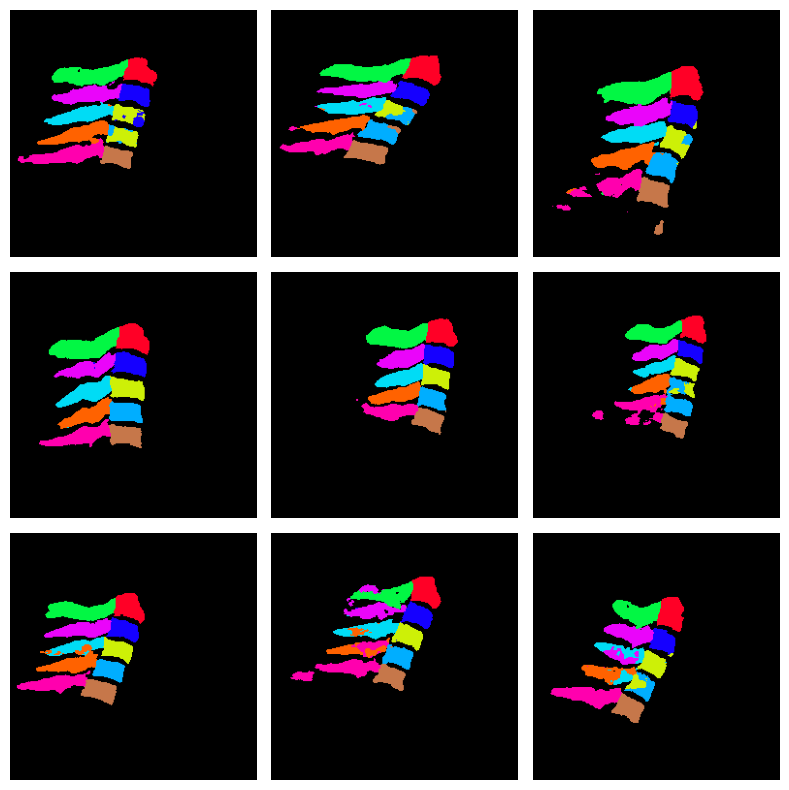

In [23]:
plot_label_image(plot_output_img)

In [24]:
import csv
path = test_result_dir
filename = 'featureCombination.csv'
full_path = os.path.join(path, filename)
with open(full_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write a single row containing the string
    writer.writerow([inputfeature_list])


In [25]:
## use the part when trying to read already trained model's results from dir

# result_test_path = '/home/eric/Documents/cervicalResearchIIP/result_test/20241024-Conv1x1-666'
# images_label_gray = []
# crf_file_names = []

# for filename in os.listdir(result_test_path):
#     # Check if the file is a PNG image
#     if filename.endswith('.png'):
#         if filename.startswith("oN"):
#             # Construct the full file path
#             print(filename)
#             crf_file_names.append(filename)
#             file_path = os.path.join(result_test_path, filename)
#             # Read the image using OpenCV
#             img = cv2.imread(file_path)
#             if img is not None:
#                 #images.append(img) color
#                 img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#                 images_label_gray.append(img_gray)  # Append the grayscale image
#             else:
#                 print(f"Failed to read image: {file_path}")

# # Now `images` contains all the loaded PNG images
# print(f"Loaded {len(images_label_gray)} images.")

# if images_label_gray:
#     print(f"Shape of the first image: {images_label_gray[0].shape}")  # This will show the dimensions of the image
# print(np.unique(images_label_gray))

# plot_label_image(images_label_gray)

In [26]:
# import pydensecrf.densecrf as dcrf
# from pydensecrf.utils import unary_from_labels, create_pairwise_gaussian

## use this part when using crf on already trained model with results
## in other words, the unet output images are in "output_img" variable

# images_label_gray = plot_output_img
## implementations regarding crf file names when using already trained model
##...


# # Segmentation output from U-Net (predicted image)
# images_label_gray = np.array(images_label_gray)
# #labels = images_label_gray[5]
# refined_labels = []
# for image_label_gray in images_label_gray:
#     print(image_label_gray.shape)



#     H, W = image_label_gray.shape
#     image_label_gray = image_label_gray.flatten()

#     print(np.unique(image_label_gray))

#     invalid_indices = np.where((image_label_gray < 0) | (image_label_gray > 10))

#     # Check if there are any invalid indices
#     if invalid_indices[0].size > 0:
#         print("Invalid label indices:", invalid_indices[0])  # Print the flat indices of invalid labels
#         print("Invalid label values:", image_label_gray[invalid_indices])  # Print the invalid label values
#     else:
#         print("All labels are within the valid range (0 to 10).")


#     # Create a dense CRF model
#     num_classes = 11  # 0 to 10, so 11 classes
#     d = dcrf.DenseCRF2D(W, H, num_classes)  # (width, height, num_classes)

#     # Create unary potentials
#     unary = unary_from_labels(image_label_gray, n_labels = num_classes, gt_prob=0.7, zero_unsure = False)
#     d.setUnaryEnergy(unary)

#     # Add pairwise terms (spatial & appearance smoothness)
#     d.addPairwiseGaussian(sxy=3, compat=10)

#     # Inference
#     Q = d.inference(5)  # Perform 5 CRF iterations

#     # Convert Q into a label image
#     refined_label = np.argmax(Q, axis=0)  # Most probable class for each pixel

#     # Reshape back to the original image shape
#     refined_label = refined_label.reshape((H, W))
#     refined_labels.append(np.array(refined_label))


# preCRF = images_label_gray
# postCRF = refined_labels


# plot_label_image(preCRF)
# plot_label_image(postCRF)

In [156]:
# #crftestdir = str(root_dir / "result_test"  / "abstractresult" / "thorough" / "unetpure" / date_str / str(OUTPUT_DIR) / "crf/" )
# crftestdir = str(root_dir / "result_test"  / "abstractresult" / "thorough" / "unetconvmultip" / "20241029-Conv1x1-26")
# print(crftestdir)
# import numpy as np
# from PIL import Image

# # # Assuming 'refined_labels' is your NumPy array with shape (H, W)
# # # Convert the array to uint8 type if necessary
# # for index, refined_label in enumerate(refined_labels):
# #     refined_label_uint8 = refined_label.astype(np.uint8)
# #     # Create a PIL image from the NumPy array
# #     image = Image.fromarray(refined_label_uint8)
# #     # Save the crf refined images to the specified crf folder    
# #     image.save(crftestdir + "/" + crf_file_names[index]) 

/home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-32


In [157]:

# crf_test_imgs_name = []

# crf_test_imgs_name.append('oN2-4')
    
# #for crf_test_pre in TEST:
# #     crf_test_imgs_name.extend(file_names_with_prefix(crftestdir, crf_test_pre))

# print(crf_test_imgs_name)

# Dice = cal_DiceMulitple(crftestdir, crf_test_imgs_name)
# df = pd.DataFrame(Dice)
# df = df.T


# #df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加


['oN2-4']
index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/abstractresult/thorough/unetconvmultip/20241029-Conv1x1-32/oN2-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN2-4.png
Count1 =  [58215, 1315, 814, 862, 587, 501, 581, 556, 491, 1008, 606]
Count2 =  [57949, 1152, 823, 809, 670, 672, 640, 679, 561, 953, 628]
Count3 =  [57349, 1119, 743, 772, 580, 389, 511, 240, 462, 527, 562]
Dice =  [0.9873799111600841, 0.9071747061207945, 0.9077580940745266, 0.9239976062238181, 0.9228321400159109, 0.6632566069906224, 0.8370188370188371, 0.38866396761133604, 0.8783269961977186, 0.5374808771035187, 0.9108589951377634, 0.7877368826494846]
